#Import Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import numpy as np
from numpy import ones
from numpy import zeros
from numpy import asarray
from numpy import load
from os import listdir
from numpy import asarray
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from numpy import savez_compressed
import matplotlib.pyplot as plt
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Activation, Concatenate, Dropout, Conv2DTranspose

In [ ]:
!pip install tensorflow
!pip install keras

#Dataset Loading and Preprocessing

Loads satellite-map image pairs from Google Drive, splits them into input (satellite) and target (map) components, converts to numpy arrays, and saves as a compressed .npz file for efficient storage.

In [ ]:
def load_images(path, size=(256,512)):
	source, target = list(), list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		source.append(sat_img)
		target.append(map_img)
	return [asarray(source), asarray(target)]


path = '/content/drive/MyDrive/maps/train/'
[main_img, final_img] = load_images(path)
print('Loaded: ', main_img.shape, final_img.shape)
filename = 'data_as_array.npz'
savez_compressed(filename, main_img, final_img)
print('Saved dataset: ', filename)

Loaded:  (10, 256, 256, 3) (10, 256, 256, 3)
Saved dataset:  data_as_array.npz


In [ ]:
import tensorflow as tf
import numpy as np

input_test = tf.data.Dataset.from_tensor_slices(main_img)
target_test = tf.data.Dataset.from_tensor_slices(final_img)


# Convert test data to NumPy arrays
test_inputs = []
test_targets = []

for img, lbl in tf.data.Dataset.zip((input_test, target_test)).take(30):
    test_inputs.append(img.numpy())
    test_targets.append(lbl.numpy())

test_inputs = np.array(test_inputs)
test_targets = np.array(test_targets)

print("Extracted test samples:", len(test_inputs))

Extracted test samples: 10


In [ ]:
test_inputs = np.array(test_inputs).astype(np.float32)
test_targets = np.array(test_targets).astype(np.float32)

print("Input range-1:", np.min(test_inputs[0]), "to", np.max(test_inputs[0]))
print("Target range-1:", np.min(test_targets[0]), "to", np.max(test_targets[0]))

test_inputs = test_inputs.astype(np.float32) / 255.0
test_targets = test_targets.astype(np.float32) / 255.0

print("✅ Normalized input-2:", np.min(test_inputs[0]), "to", np.max(test_inputs[0]))
print("✅ Normalized target-2:", np.min(test_targets[0]), "to", np.max(test_targets[0]))

Input range-1: 0.0 to 236.0
Target range-1: 105.0 to 255.0
✅ Normalized input-2: 0.0 to 0.9254902
✅ Normalized target-2: 0.4117647 to 1.0


# Dataset Visualization

Loads the preprocessed dataset and displays sample image pairs (3 satellite images and their corresponding map images) in a grid to verify data alignment and formatting.

Loaded:  (10, 256, 256, 3) (10, 256, 256, 3)


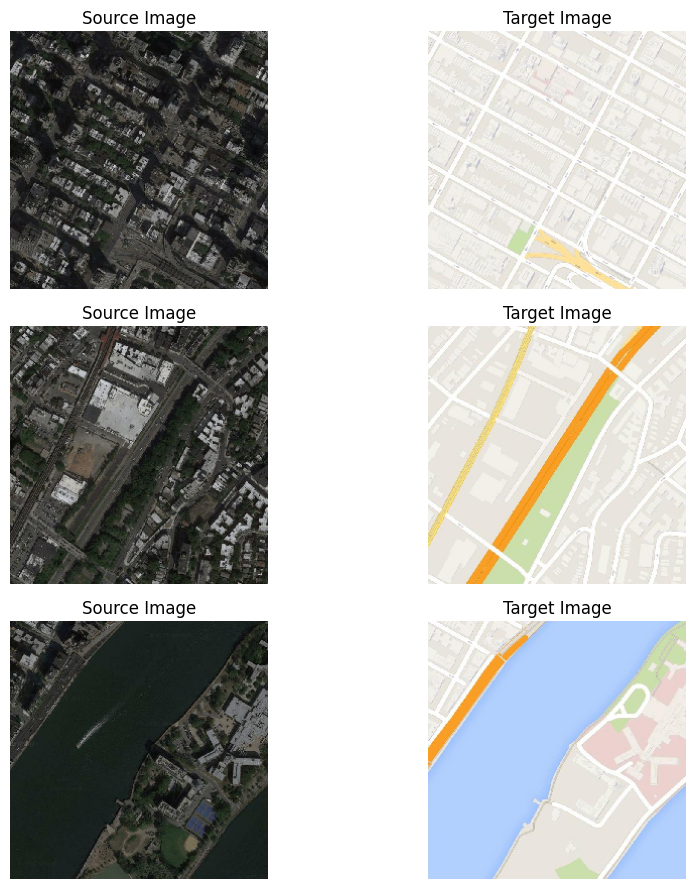

In [ ]:
data = load('data_as_array.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)

n_samples = 3

fig, axes = plt.subplots(nrows=n_samples, ncols=2, figsize=(10, 3*n_samples))
for i in range(n_samples):
    axes[i, 0].imshow(src_images[i].astype('uint8'))
    axes[i, 0].set_title("Source Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(tar_images[i].astype('uint8'))
    axes[i, 1].set_title("Target Image")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Adding Distortions: Noise, Blur, and Occlusion to Input Images

This block defines functions to simulate real-world distortions on satellite images — including Gaussian noise, Gaussian blur, and random occlusions — and applies them systematically to the test dataset to evaluate model robustness.

In [ ]:
import cv2
import numpy as np
import random

# --- Noise/Blur/Occlusion Functions ---
def add_gaussian_noise(img, mean=0, var=0.01):
    row, col, ch = img.shape
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy = img + gauss
    return np.clip(noisy, 0, 1)

def add_blur(img, kernel_size=(5, 5)):
    return cv2.GaussianBlur(img, kernel_size, 0)

def add_occlusion(img, size=30):
    img = img.copy()
    h, w, _ = img.shape
    x = random.randint(0, w - size)
    y = random.randint(0, h - size)
    img[y:y+size, x:x+size] = 0
    return img

def apply_corruptions(images):
    corrupted = []
    for img in images:
        img = img.astype(np.float32) / 255.0
        noisy = add_gaussian_noise(img)
        blurred = add_blur(img)
        occluded = add_occlusion(img)

        corrupted.append({
            'original': img,
            'noisy': noisy,
            'blurred': blurred,
            'occluded': occluded
        })
    return corrupted

corrupted_images = apply_corruptions(test_inputs)


In [ ]:
print("✅ Normalized input-1:", np.min(test_inputs[0]), "to", np.max(test_inputs[0]))
print("✅ Normalized target-1:", np.min(test_targets[0]), "to", np.max(test_targets[0]))

test_inputs = test_inputs.astype(np.float32) / 255.0
test_targets = test_targets.astype(np.float32) / 255.0

print("✅ Normalized input-2:", np.min(test_inputs[0]), "to", np.max(test_inputs[0]))
print("✅ Normalized target-2:", np.min(test_targets[0]), "to", np.max(test_targets[0]))

✅ Normalized input-1: 0.0 to 236.0
✅ Normalized target-1: 105.0 to 255.0
✅ Normalized input-2: 0.0 to 0.9254902
✅ Normalized target-2: 0.4117647 to 1.0


#Discriminator Model Architecture

Defines a PatchGAN discriminator model that distinguishes between real and fake image pairs (satellite → map). Uses a series of convolutional layers with leaky ReLU activation, batch normalization, and a final sigmoid output to classify image patches as real or synthetic.

Key Details:

* Architecture : 5 convolutional blocks with increasing filters (64→512)
* Input : Paired images (source + target) concatenated along the channel dimension
* Output : Probability map (sigmoid activation) indicating real/fake at patch level
* Optimizer : Adam with learning rate 0.0002 and β₁=0.5 (standard for GANs)
* Loss : Binary cross-entropy with 0.5 loss weight (common in Pix2Pix implementations)

In [ ]:
def Discriminator(image_shape):
	init = RandomNormal(stddev=0.02)
	source_input_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([source_input_image, in_target_image])

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)


	model = Model([source_input_image, in_target_image], patch_out)

	optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=optimiser, loss_weights=[0.5])
	return model

#Encoder and Decoder Block and Weight Initialisation

Define an encoder-decoder U-Net style generator model for image-to-image translation tasks.

In [ ]:
def Encoder(input_layer, filter_count, batchnorm=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2D(filter_count, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input_layer)
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

def Decoder(input_layer, skip_in, filter_count, dropout=True):
	init = RandomNormal(stddev=0.02)
	g = Conv2DTranspose(filter_count, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(input_layer)
	g = BatchNormalization()(g, training=True)
	if dropout:
		g = Dropout(0.5)(g, training=True)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

def Generator(image_shape=(256,256,3)):
	init = RandomNormal(stddev=0.02)
	in_image = Input(shape=image_shape)
	e1 = Encoder(in_image, 64, batchnorm=False)
	e2 = Encoder(e1, 128)
	e3 = Encoder(e2, 256)
	e4 = Encoder(e3, 512)
	e5 = Encoder(e4, 512)
	e6 = Encoder(e5, 512)
	e7 = Encoder(e6, 512)

	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)

	d1 = Decoder(b, e7, 512)
	d2 = Decoder(d1, e6, 512)
	d3 = Decoder(d2, e5, 512)
	d4 = Decoder(d3, e4, 512, dropout=False)
	d5 = Decoder(d4, e3, 256, dropout=False)
	d6 = Decoder(d5, e2, 128, dropout=False)
	d7 = Decoder(d6, e1, 64, dropout=False)

	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	model = Model(in_image, out_image)
	return model

#GAN Model Definition and Scaling the data

Combine the generator and discriminator models into a single end-to-end GAN architecture for training. Also, we load preprocessed dataset and scales pixel values from [0, 255] to [-1, 1] to match the generator’s output range.

In [ ]:
def GAN(generator_model, discriminator_model, image_shape):
	for layer in discriminator_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	source_input = Input(shape=image_shape)
	output_generator = generator_model(source_input)
	output_discriminator = discriminator_model([source_input, output_generator])
	model = Model(source_input, [output_discriminator, output_generator])

	optimiser = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=optimiser, loss_weights=[1,100])
	return model

#Real and Fake Sample Generation

Generates real and fake image pairs for training the discriminator. This is an important step in the process of a Conditional GAN.

In [ ]:
def original_samples(dataset, source_images, patch_shape):
	train1, train2 = dataset
	ix = randint(0, train1.shape[0], source_images)
	dataset_image, target_image = train1[ix], train2[ix]
	y = ones((source_images, patch_shape, patch_shape, 1))
	return [dataset_image, target_image], y

def fake_samples(generator_model, samples, patch_shape):
	X = generator_model.predict(samples)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# Save Training Progress at Intervals

Generates and saves a visualization of real and generated image pairs, along with saving the generator model at specified intervals. This helps us to load the required pre-trained model for testing on a random input.

In [ ]:
def save_model(step, generator_model, dataset, source_images=3):
	[real_image1, real_image2], _ = original_samples(dataset, source_images, 1)
	fake_image, _ = fake_samples(generator_model, real_image1, 1)
	real_image1 = (real_image1 + 1) / 2.0
	real_image2 = (real_image2 + 1) / 2.0
	fake_image = (fake_image + 1) / 2.0

	for i in range(source_images):
		pyplot.subplot(3, source_images, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(real_image1[i])

	for i in range(source_images):
		pyplot.subplot(3, source_images, 1 + source_images + i)
		pyplot.axis('off')
		pyplot.imshow(fake_image[i])

	for i in range(source_images):
		pyplot.subplot(3, source_images, 1 + source_images*2 + i)
		pyplot.axis('off')
		pyplot.imshow(real_image2[i])

	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()

	filename2 = f'generator_epoch_{step+1}.h5'
	generator_model.save(filename2)
	print(f'>Saved: {filename1} and {filename2}')

In [ ]:
print("✅ Normalized input-1:", np.min(test_inputs[0]), "to", np.max(test_inputs[0]))
print("✅ Normalized target-1:", np.min(test_targets[0]), "to", np.max(test_targets[0]))

✅ Normalized input-1: 0.0 to 0.9254902
✅ Normalized target-1: 0.4117647 to 1.0


# Training the Pix2Pix Model

Trains the discriminator, generator, and GAN models together using the Pix2Pix framework.

In [ ]:
def load_real_samples(filename):
    data = load(filename)
    dataset_image, target_image = data['arr_0'], data['arr_1']
    dataset_image = (dataset_image - 127.5) / 127.5
    target_image = (target_image - 127.5) / 127.5
    return [dataset_image, target_image]

# train pix2pix model
def train(discriminator_model, generator_model, gan_model, dataset, n_epochs=200, n_batch=1):
	n_patch = discriminator_model.output_shape[1]
	train1, train2 = dataset
	batch_per_epoch = int(len(train1) / n_batch)
	n_steps = batch_per_epoch * n_epochs
	for i in range(n_steps):
		[real_image1, real_image2], y_real = original_samples(dataset, n_batch, n_patch)
		fake_image, y_fake = fake_samples(generator_model, real_image1, n_patch)
		d_loss1 = discriminator_model.train_on_batch([real_image1, real_image2], y_real)
		d_loss2 = discriminator_model.train_on_batch([real_image1, fake_image], y_fake)
		g_loss = gan_model.train_on_batch(real_image1, [y_real, real_image2])
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f, %.3f]' % (i+1, d_loss1, d_loss2, g_loss[0], g_loss[1]))
		if (i+1) % (batch_per_epoch) == 0:
			save_model(i, generator_model, dataset)

# load image data
dataset = load_real_samples('data_as_array.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
image_shape = dataset[0].shape[1:]
discriminator_model = Discriminator(image_shape)
generator_model = Generator(image_shape)
gan_model = GAN(generator_model, discriminator_model, image_shape)
train(discriminator_model, generator_model, gan_model, dataset)

Loaded (10, 256, 256, 3) (10, 256, 256, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
>1, d1[0.529] d2[0.420] g[86.974, 1.098]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>2, d1[0.459] d2[0.427] g[85.328, 1.081]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>3, d1[0.446] d2[0.424] g[84.124, 1.033]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>4, d1[0.442] d2[0.427] g[82.717, 1.051]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>5, d1[0.439] d2[0.427] g[81.045, 1.050]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>6, d1[0.436] d2[0.428] g[79.711, 1.034]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>7, d1[0.436] d2[0.428] g[78.448, 1.033]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>8, d1[0.433] d2[0.427] g[75.682, 1.027]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>9, d1[0.433] d2[0.427] g[74.188, 1.027]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>10, d1[0.432] d2[0.428] g[73.023, 1.019]
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


>Saved: plot_000010.png and generator_epoch_10.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>11, d1[0.432] d2[0.427] g[71.898, 1.019]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>12, d1[0.432] d2[0.428] g[70.738, 1.021]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>13, d1[0.431] d2[0.428] g[69.508, 1.014]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>14, d1[0.431] d2[0.428] g[68.269, 1.012]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>15, d1[0.431] d2[0.428] g[67.010, 1.005]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>16, d1[0.431] d2[0.428] g[65.773, 1.002]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>17, d1[0.430] d2[0.427] g[64.595, 1.001]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>18, d1[0.430] d2[0.427] g[63.364, 0.996]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>19, d1[0.430] d2[0.428] g[62.165, 0.997]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
>20, d1[0.429] d2[0.427] g[60.707, 0.994]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


>Saved: plot_000020.png and generator_epoch_20.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>21, d1[0.429] d2[0.427] g[59.539, 0.990]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>22, d1[0.429] d2[0.427] g[58.397, 0.991]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>23, d1[0.428] d2[0.427] g[57.259, 0.990]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>24, d1[0.429] d2[0.427] g[56.130, 0.990]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>25, d1[0.428] d2[0.427] g[55.039, 0.989]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>26, d1[0.428] d2[0.427] g[53.927, 0.989]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>27, d1[0.428] d2[0.427] g[52.781, 0.988]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>28, d1[0.428] d2[0.426] g[51.740, 0.987]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>29, d1[0.427] d2[0.426] g[50.688, 0.985]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>30, d1[0.427] d2[0.425] g[49.650, 0.984]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000030.png and generator_epoch_30.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>31, d1[0.426] d2[0.425] g[48.673, 0.981]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>32, d1[0.426] d2[0.425] g[47.676, 0.980]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>33, d1[0.426] d2[0.425] g[46.702, 0.980]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>34, d1[0.426] d2[0.425] g[45.755, 0.979]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>35, d1[0.426] d2[0.425] g[44.834, 0.978]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>36, d1[0.425] d2[0.425] g[44.008, 0.976]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>37, d1[0.425] d2[0.425] g[43.114, 0.974]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>38, d1[0.425] d2[0.425] g[42.375, 0.973]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>39, d1[0.425] d2[0.425] g[41.579, 0.973]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>40, d1[0.425] d2[0.425] g[40.780, 0.971]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000040.png and generator_epoch_40.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>41, d1[0.425] d2[0.424] g[40.022, 0.970]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>42, d1[0.425] d2[0.424] g[39.295, 0.968]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>43, d1[0.425] d2[0.424] g[38.635, 0.967]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>44, d1[0.425] d2[0.424] g[38.061, 0.966]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>45, d1[0.424] d2[0.424] g[37.406, 0.964]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>46, d1[0.424] d2[0.424] g[36.812, 0.963]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>47, d1[0.424] d2[0.424] g[36.237, 0.961]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>48, d1[0.424] d2[0.424] g[35.753, 0.960]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>49, d1[0.424] d2[0.424] g[35.206, 0.959]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>50, d1[0.424] d2[0.423] g[34.795, 0.957]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


>Saved: plot_000050.png and generator_epoch_50.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>51, d1[0.424] d2[0.423] g[34.560, 0.956]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>52, d1[0.423] d2[0.423] g[34.299, 0.954]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>53, d1[0.423] d2[0.423] g[33.985, 0.952]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>54, d1[0.423] d2[0.423] g[33.537, 0.951]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>55, d1[0.423] d2[0.423] g[33.086, 0.949]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>56, d1[0.423] d2[0.423] g[32.679, 0.947]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>57, d1[0.423] d2[0.422] g[32.254, 0.946]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>58, d1[0.422] d2[0.422] g[32.085, 0.944]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>59, d1[0.422] d2[0.422] g[31.783, 0.942]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>60, d1[0.422] d2[0.422] g[31.408, 0.942]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


>Saved: plot_000060.png and generator_epoch_60.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>61, d1[0.422] d2[0.422] g[31.038, 0.941]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>62, d1[0.422] d2[0.422] g[30.662, 0.939]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>63, d1[0.422] d2[0.422] g[30.536, 0.937]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>64, d1[0.422] d2[0.422] g[30.264, 0.936]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>65, d1[0.422] d2[0.422] g[29.930, 0.934]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>66, d1[0.422] d2[0.422] g[29.798, 0.933]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>67, d1[0.422] d2[0.421] g[29.489, 0.931]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>68, d1[0.421] d2[0.421] g[29.171, 0.929]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>69, d1[0.421] d2[0.421] g[28.944, 0.927]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>70, d1[0.421] d2[0.421] g[28.665, 0.926]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000070.png and generator_epoch_70.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>71, d1[0.421] d2[0.421] g[28.380, 0.925]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>72, d1[0.421] d2[0.421] g[28.154, 0.923]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>73, d1[0.421] d2[0.421] g[27.882, 0.922]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>74, d1[0.421] d2[0.421] g[27.796, 0.921]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>75, d1[0.421] d2[0.421] g[27.594, 0.919]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>76, d1[0.421] d2[0.421] g[27.395, 0.917]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>77, d1[0.421] d2[0.421] g[27.164, 0.916]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>78, d1[0.421] d2[0.421] g[26.977, 0.914]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>79, d1[0.421] d2[0.421] g[26.738, 0.913]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>80, d1[0.421] d2[0.421] g[26.667, 0.912]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000080.png and generator_epoch_80.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>81, d1[0.421] d2[0.421] g[26.487, 0.910]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>82, d1[0.421] d2[0.421] g[26.268, 0.909]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>83, d1[0.420] d2[0.420] g[26.187, 0.907]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>84, d1[0.420] d2[0.420] g[26.013, 0.905]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>85, d1[0.420] d2[0.420] g[25.855, 0.904]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>86, d1[0.420] d2[0.420] g[25.763, 0.902]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>87, d1[0.420] d2[0.420] g[25.593, 0.900]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>88, d1[0.420] d2[0.420] g[25.408, 0.900]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>89, d1[0.420] d2[0.420] g[25.243, 0.898]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>90, d1[0.420] d2[0.420] g[25.060, 0.896]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000090.png and generator_epoch_90.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>91, d1[0.420] d2[0.420] g[24.889, 0.895]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>92, d1[0.420] d2[0.420] g[24.745, 0.893]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>93, d1[0.420] d2[0.420] g[24.571, 0.892]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>94, d1[0.420] d2[0.420] g[24.400, 0.890]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>95, d1[0.420] d2[0.420] g[24.348, 0.889]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>96, d1[0.420] d2[0.420] g[24.191, 0.888]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>97, d1[0.420] d2[0.420] g[24.053, 0.886]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>98, d1[0.420] d2[0.420] g[23.888, 0.884]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>99, d1[0.419] d2[0.420] g[23.824, 0.883]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>100, d1[0.419] d2[0.420] g[23.710, 0.881]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_000100.png and generator_epoch_100.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>101, d1[0.419] d2[0.420] g[23.635, 0.880]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>102, d1[0.419] d2[0.419] g[23.489, 0.879]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>103, d1[0.419] d2[0.419] g[23.413, 0.877]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>104, d1[0.419] d2[0.419] g[23.276, 0.876]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>105, d1[0.419] d2[0.419] g[23.137, 0.875]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>106, d1[0.419] d2[0.419] g[23.003, 0.874]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>107, d1[0.419] d2[0.419] g[22.948, 0.872]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>108, d1[0.419] d2[0.419] g[22.849, 0.871]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>109, d1[0.419] d2[0.419] g[22.764, 0.869]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>110, d1[0.419] d2[0.419] g[22.639, 0.868]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000110.png and generator_epoch_110.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>111, d1[0.419] d2[0.419] g[22.593, 0.867]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>112, d1[0.419] d2[0.419] g[22.469, 0.866]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>113, d1[0.419] d2[0.419] g[22.410, 0.864]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>114, d1[0.419] d2[0.419] g[22.290, 0.863]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>115, d1[0.419] d2[0.419] g[22.190, 0.862]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>116, d1[0.419] d2[0.419] g[22.071, 0.860]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>117, d1[0.419] d2[0.419] g[21.953, 0.859]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>118, d1[0.419] d2[0.419] g[21.896, 0.858]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>119, d1[0.419] d2[0.419] g[21.784, 0.857]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>120, d1[0.419] d2[0.419] g[21.671, 0.856]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


>Saved: plot_000120.png and generator_epoch_120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>121, d1[0.418] d2[0.419] g[21.595, 0.855]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>122, d1[0.418] d2[0.419] g[21.506, 0.853]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>123, d1[0.418] d2[0.419] g[21.392, 0.852]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>124, d1[0.418] d2[0.419] g[21.289, 0.851]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>125, d1[0.418] d2[0.419] g[21.240, 0.850]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>126, d1[0.418] d2[0.419] g[21.135, 0.848]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>127, d1[0.418] d2[0.419] g[21.026, 0.847]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>128, d1[0.418] d2[0.418] g[20.920, 0.846]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>129, d1[0.418] d2[0.418] g[20.853, 0.845]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>130, d1[0.418] d2[0.418] g[20.747, 0.843]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


>Saved: plot_000130.png and generator_epoch_130.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>131, d1[0.418] d2[0.418] g[20.704, 0.842]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>132, d1[0.418] d2[0.418] g[20.627, 0.841]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>133, d1[0.418] d2[0.418] g[20.547, 0.839]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>134, d1[0.418] d2[0.418] g[20.448, 0.838]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>135, d1[0.418] d2[0.418] g[20.353, 0.837]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>136, d1[0.418] d2[0.418] g[20.255, 0.836]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>137, d1[0.418] d2[0.418] g[20.219, 0.834]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>138, d1[0.418] d2[0.418] g[20.162, 0.833]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>139, d1[0.418] d2[0.418] g[20.068, 0.832]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>140, d1[0.418] d2[0.418] g[19.980, 0.831]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000140.png and generator_epoch_140.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>141, d1[0.418] d2[0.418] g[19.925, 0.830]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>142, d1[0.418] d2[0.418] g[19.892, 0.829]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>143, d1[0.418] d2[0.418] g[19.836, 0.828]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>144, d1[0.418] d2[0.418] g[19.751, 0.827]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>145, d1[0.418] d2[0.418] g[19.670, 0.826]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>146, d1[0.418] d2[0.418] g[19.618, 0.825]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>147, d1[0.418] d2[0.418] g[19.534, 0.824]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>148, d1[0.418] d2[0.418] g[19.448, 0.822]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>149, d1[0.418] d2[0.418] g[19.364, 0.821]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>150, d1[0.418] d2[0.418] g[19.287, 0.820]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_000150.png and generator_epoch_150.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>151, d1[0.418] d2[0.418] g[19.231, 0.819]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>152, d1[0.418] d2[0.418] g[19.169, 0.818]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>153, d1[0.418] d2[0.418] g[19.094, 0.817]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>154, d1[0.418] d2[0.418] g[19.046, 0.816]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>155, d1[0.418] d2[0.418] g[18.972, 0.815]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
>156, d1[0.418] d2[0.418] g[18.900, 0.814]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>157, d1[0.418] d2[0.418] g[18.823, 0.813]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>158, d1[0.418] d2[0.418] g[18.776, 0.812]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>159, d1[0.418] d2[0.418] g[18.757, 0.810]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
>160, d1[0.418] d2[0.418] g[18.684, 0.809]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000160.png and generator_epoch_160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>161, d1[0.418] d2[0.418] g[18.630, 0.808]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>162, d1[0.418] d2[0.418] g[18.600, 0.807]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>163, d1[0.418] d2[0.418] g[18.558, 0.806]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>164, d1[0.418] d2[0.418] g[18.528, 0.805]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>165, d1[0.418] d2[0.418] g[18.487, 0.804]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>166, d1[0.418] d2[0.418] g[18.454, 0.803]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>167, d1[0.418] d2[0.418] g[18.392, 0.802]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>168, d1[0.418] d2[0.418] g[18.328, 0.801]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>169, d1[0.418] d2[0.418] g[18.277, 0.800]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>170, d1[0.418] d2[0.418] g[18.213, 0.798]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000170.png and generator_epoch_170.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>171, d1[0.418] d2[0.418] g[18.154, 0.797]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>172, d1[0.418] d2[0.418] g[18.115, 0.796]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>173, d1[0.418] d2[0.418] g[18.080, 0.795]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>174, d1[0.418] d2[0.418] g[18.037, 0.794]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>175, d1[0.418] d2[0.418] g[17.977, 0.793]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>176, d1[0.418] d2[0.418] g[17.950, 0.792]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>177, d1[0.418] d2[0.418] g[17.893, 0.791]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>178, d1[0.418] d2[0.418] g[17.832, 0.790]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>179, d1[0.418] d2[0.418] g[17.801, 0.789]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>180, d1[0.417] d2[0.418] g[17.774, 0.788]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


>Saved: plot_000180.png and generator_epoch_180.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>181, d1[0.418] d2[0.418] g[17.717, 0.787]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>182, d1[0.418] d2[0.418] g[17.663, 0.786]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>183, d1[0.418] d2[0.418] g[17.605, 0.786]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>184, d1[0.418] d2[0.418] g[17.547, 0.785]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>185, d1[0.418] d2[0.418] g[17.523, 0.784]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>186, d1[0.418] d2[0.418] g[17.493, 0.783]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>187, d1[0.418] d2[0.418] g[17.436, 0.782]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>188, d1[0.418] d2[0.418] g[17.404, 0.781]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>189, d1[0.418] d2[0.418] g[17.349, 0.780]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>190, d1[0.418] d2[0.418] g[17.323, 0.779]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_000190.png and generator_epoch_190.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>191, d1[0.418] d2[0.418] g[17.268, 0.778]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>192, d1[0.418] d2[0.418] g[17.215, 0.777]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>193, d1[0.418] d2[0.418] g[17.189, 0.776]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>194, d1[0.418] d2[0.418] g[17.159, 0.775]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>195, d1[0.418] d2[0.418] g[17.105, 0.774]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>196, d1[0.418] d2[0.418] g[17.075, 0.773]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>197, d1[0.418] d2[0.418] g[17.025, 0.772]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>198, d1[0.418] d2[0.418] g[16.995, 0.771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>199, d1[0.418] d2[0.418] g[16.948, 0.771]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>200, d1[0.418] d2[0.418] g[16.898, 0.770]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


>Saved: plot_000200.png and generator_epoch_200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>201, d1[0.418] d2[0.418] g[16.846, 0.769]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>202, d1[0.418] d2[0.418] g[16.817, 0.768]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>203, d1[0.418] d2[0.418] g[16.787, 0.767]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>204, d1[0.418] d2[0.418] g[16.741, 0.766]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>205, d1[0.418] d2[0.418] g[16.693, 0.765]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>206, d1[0.418] d2[0.418] g[16.663, 0.764]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>207, d1[0.418] d2[0.418] g[16.613, 0.763]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>208, d1[0.418] d2[0.418] g[16.599, 0.762]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>209, d1[0.418] d2[0.418] g[16.582, 0.761]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>210, d1[0.418] d2[0.418] g[16.561, 0.760]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000210.png and generator_epoch_210.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>211, d1[0.418] d2[0.418] g[16.532, 0.759]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>212, d1[0.418] d2[0.418] g[16.489, 0.759]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>213, d1[0.418] d2[0.418] g[16.447, 0.758]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>214, d1[0.418] d2[0.418] g[16.438, 0.757]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>215, d1[0.418] d2[0.418] g[16.395, 0.756]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>216, d1[0.418] d2[0.418] g[16.354, 0.755]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>217, d1[0.418] d2[0.418] g[16.324, 0.754]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>218, d1[0.418] d2[0.418] g[16.286, 0.753]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>219, d1[0.418] d2[0.418] g[16.243, 0.752]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>220, d1[0.418] d2[0.418] g[16.213, 0.752]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000220.png and generator_epoch_220.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>221, d1[0.418] d2[0.418] g[16.171, 0.751]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>222, d1[0.418] d2[0.418] g[16.129, 0.750]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>223, d1[0.418] d2[0.418] g[16.084, 0.749]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>224, d1[0.418] d2[0.418] g[16.064, 0.748]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>225, d1[0.418] d2[0.418] g[16.041, 0.747]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>226, d1[0.418] d2[0.418] g[16.010, 0.746]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>227, d1[0.418] d2[0.418] g[15.967, 0.746]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>228, d1[0.418] d2[0.418] g[15.950, 0.745]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>229, d1[0.418] d2[0.418] g[15.922, 0.744]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>230, d1[0.418] d2[0.418] g[15.902, 0.743]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000230.png and generator_epoch_230.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>231, d1[0.418] d2[0.418] g[15.883, 0.742]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>232, d1[0.418] d2[0.418] g[15.848, 0.741]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>233, d1[0.418] d2[0.418] g[15.807, 0.740]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>234, d1[0.418] d2[0.418] g[15.771, 0.740]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>235, d1[0.418] d2[0.418] g[15.730, 0.739]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>236, d1[0.418] d2[0.418] g[15.689, 0.738]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>237, d1[0.418] d2[0.418] g[15.675, 0.737]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>238, d1[0.418] d2[0.418] g[15.650, 0.736]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>239, d1[0.418] d2[0.418] g[15.631, 0.735]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>240, d1[0.418] d2[0.418] g[15.593, 0.734]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000240.png and generator_epoch_240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>241, d1[0.418] d2[0.418] g[15.555, 0.733]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>242, d1[0.418] d2[0.418] g[15.522, 0.733]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>243, d1[0.418] d2[0.418] g[15.505, 0.732]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>244, d1[0.418] d2[0.418] g[15.488, 0.731]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>245, d1[0.418] d2[0.418] g[15.468, 0.730]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>246, d1[0.418] d2[0.418] g[15.441, 0.729]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>247, d1[0.418] d2[0.418] g[15.422, 0.729]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>248, d1[0.418] d2[0.418] g[15.403, 0.728]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>249, d1[0.418] d2[0.418] g[15.368, 0.727]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>250, d1[0.418] d2[0.418] g[15.335, 0.726]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


>Saved: plot_000250.png and generator_epoch_250.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>251, d1[0.418] d2[0.418] g[15.304, 0.726]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>252, d1[0.418] d2[0.418] g[15.270, 0.725]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>253, d1[0.418] d2[0.418] g[15.261, 0.724]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>254, d1[0.418] d2[0.418] g[15.248, 0.723]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>255, d1[0.418] d2[0.418] g[15.217, 0.723]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>256, d1[0.418] d2[0.419] g[15.191, 0.722]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>257, d1[0.418] d2[0.419] g[15.160, 0.721]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>258, d1[0.418] d2[0.419] g[15.143, 0.720]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>259, d1[0.418] d2[0.419] g[15.111, 0.720]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>260, d1[0.418] d2[0.419] g[15.100, 0.719]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000260.png and generator_epoch_260.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>261, d1[0.418] d2[0.419] g[15.084, 0.718]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>262, d1[0.418] d2[0.419] g[15.068, 0.717]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>263, d1[0.418] d2[0.419] g[15.040, 0.717]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>264, d1[0.418] d2[0.419] g[15.009, 0.716]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>265, d1[0.418] d2[0.419] g[14.997, 0.715]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>266, d1[0.418] d2[0.419] g[14.965, 0.715]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>267, d1[0.418] d2[0.419] g[14.932, 0.714]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>268, d1[0.418] d2[0.419] g[14.899, 0.713]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>269, d1[0.418] d2[0.419] g[14.883, 0.712]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>270, d1[0.418] d2[0.419] g[14.862, 0.711]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


>Saved: plot_000270.png and generator_epoch_270.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>271, d1[0.418] d2[0.419] g[14.830, 0.711]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>272, d1[0.418] d2[0.419] g[14.798, 0.710]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>273, d1[0.418] d2[0.419] g[14.776, 0.709]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>274, d1[0.418] d2[0.419] g[14.761, 0.708]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>275, d1[0.418] d2[0.419] g[14.730, 0.708]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>276, d1[0.418] d2[0.419] g[14.703, 0.707]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>277, d1[0.419] d2[0.419] g[14.671, 0.706]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>278, d1[0.419] d2[0.419] g[14.652, 0.706]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>279, d1[0.419] d2[0.419] g[14.626, 0.705]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>280, d1[0.419] d2[0.419] g[14.614, 0.704]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


>Saved: plot_000280.png and generator_epoch_280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>281, d1[0.419] d2[0.419] g[14.597, 0.703]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>282, d1[0.419] d2[0.419] g[14.567, 0.703]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>283, d1[0.419] d2[0.419] g[14.535, 0.702]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>284, d1[0.419] d2[0.419] g[14.518, 0.701]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>285, d1[0.419] d2[0.419] g[14.488, 0.701]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>286, d1[0.419] d2[0.419] g[14.462, 0.700]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>287, d1[0.419] d2[0.419] g[14.441, 0.699]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>288, d1[0.419] d2[0.419] g[14.432, 0.698]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>289, d1[0.419] d2[0.419] g[14.406, 0.698]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>290, d1[0.419] d2[0.419] g[14.377, 0.697]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000290.png and generator_epoch_290.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>291, d1[0.419] d2[0.419] g[14.358, 0.696]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>292, d1[0.419] d2[0.419] g[14.341, 0.696]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>293, d1[0.419] d2[0.419] g[14.329, 0.695]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>294, d1[0.419] d2[0.419] g[14.312, 0.694]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>295, d1[0.419] d2[0.419] g[14.286, 0.694]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>296, d1[0.419] d2[0.419] g[14.276, 0.693]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>297, d1[0.419] d2[0.419] g[14.250, 0.693]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>298, d1[0.419] d2[0.419] g[14.223, 0.692]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>299, d1[0.419] d2[0.419] g[14.195, 0.691]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>300, d1[0.419] d2[0.419] g[14.183, 0.691]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000300.png and generator_epoch_300.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>301, d1[0.419] d2[0.419] g[14.178, 0.690]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>302, d1[0.419] d2[0.419] g[14.154, 0.689]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>303, d1[0.419] d2[0.419] g[14.142, 0.689]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>304, d1[0.419] d2[0.419] g[14.118, 0.688]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>305, d1[0.419] d2[0.419] g[14.096, 0.688]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>306, d1[0.419] d2[0.419] g[14.079, 0.687]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>307, d1[0.419] d2[0.419] g[14.053, 0.686]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>308, d1[0.419] d2[0.419] g[14.039, 0.686]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>309, d1[0.419] d2[0.419] g[14.017, 0.685]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>310, d1[0.419] d2[0.419] g[13.991, 0.684]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000310.png and generator_epoch_310.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>311, d1[0.419] d2[0.419] g[13.968, 0.684]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>312, d1[0.419] d2[0.419] g[13.942, 0.683]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>313, d1[0.419] d2[0.419] g[13.918, 0.682]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>314, d1[0.419] d2[0.420] g[13.907, 0.682]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>315, d1[0.419] d2[0.420] g[13.895, 0.681]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>316, d1[0.419] d2[0.420] g[13.881, 0.681]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>317, d1[0.419] d2[0.420] g[13.869, 0.680]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>318, d1[0.419] d2[0.420] g[13.861, 0.679]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>319, d1[0.419] d2[0.420] g[13.851, 0.679]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>320, d1[0.419] d2[0.420] g[13.834, 0.678]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


>Saved: plot_000320.png and generator_epoch_320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>321, d1[0.419] d2[0.420] g[13.823, 0.677]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>322, d1[0.419] d2[0.420] g[13.802, 0.677]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>323, d1[0.419] d2[0.420] g[13.789, 0.676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>324, d1[0.420] d2[0.420] g[13.771, 0.676]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>325, d1[0.420] d2[0.420] g[13.751, 0.675]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>326, d1[0.420] d2[0.420] g[13.740, 0.674]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>327, d1[0.420] d2[0.420] g[13.719, 0.674]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>328, d1[0.420] d2[0.420] g[13.707, 0.673]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>329, d1[0.420] d2[0.420] g[13.689, 0.673]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>330, d1[0.420] d2[0.420] g[13.677, 0.672]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_000330.png and generator_epoch_330.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>331, d1[0.420] d2[0.420] g[13.655, 0.671]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>332, d1[0.420] d2[0.420] g[13.643, 0.671]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>333, d1[0.420] d2[0.420] g[13.627, 0.670]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>334, d1[0.420] d2[0.420] g[13.618, 0.669]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>335, d1[0.420] d2[0.420] g[13.597, 0.669]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>336, d1[0.420] d2[0.420] g[13.586, 0.668]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>337, d1[0.420] d2[0.420] g[13.572, 0.668]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>338, d1[0.420] d2[0.420] g[13.551, 0.667]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>339, d1[0.420] d2[0.420] g[13.539, 0.667]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>340, d1[0.420] d2[0.420] g[13.519, 0.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000340.png and generator_epoch_340.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>341, d1[0.420] d2[0.420] g[13.496, 0.666]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>342, d1[0.420] d2[0.420] g[13.472, 0.665]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>343, d1[0.420] d2[0.420] g[13.456, 0.664]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>344, d1[0.420] d2[0.420] g[13.435, 0.664]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>345, d1[0.420] d2[0.420] g[13.422, 0.663]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>346, d1[0.420] d2[0.420] g[13.402, 0.663]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>347, d1[0.420] d2[0.420] g[13.388, 0.662]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>348, d1[0.420] d2[0.420] g[13.366, 0.661]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>349, d1[0.420] d2[0.420] g[13.357, 0.661]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>350, d1[0.420] d2[0.420] g[13.336, 0.660]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000350.png and generator_epoch_350.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>351, d1[0.420] d2[0.420] g[13.333, 0.660]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>352, d1[0.420] d2[0.420] g[13.324, 0.659]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>353, d1[0.420] d2[0.420] g[13.308, 0.659]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>354, d1[0.420] d2[0.420] g[13.289, 0.658]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>355, d1[0.420] d2[0.420] g[13.267, 0.658]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>356, d1[0.420] d2[0.420] g[13.247, 0.657]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>357, d1[0.420] d2[0.420] g[13.236, 0.657]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>358, d1[0.420] d2[0.420] g[13.223, 0.656]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>359, d1[0.420] d2[0.421] g[13.213, 0.655]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>360, d1[0.420] d2[0.421] g[13.192, 0.655]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_000360.png and generator_epoch_360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>361, d1[0.420] d2[0.421] g[13.170, 0.654]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>362, d1[0.420] d2[0.421] g[13.164, 0.654]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>363, d1[0.420] d2[0.421] g[13.146, 0.653]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>364, d1[0.420] d2[0.421] g[13.125, 0.653]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>365, d1[0.420] d2[0.421] g[13.104, 0.652]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>366, d1[0.420] d2[0.421] g[13.089, 0.652]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>367, d1[0.420] d2[0.421] g[13.080, 0.651]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>368, d1[0.420] d2[0.421] g[13.064, 0.651]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>369, d1[0.420] d2[0.421] g[13.046, 0.650]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>370, d1[0.420] d2[0.421] g[13.025, 0.650]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000370.png and generator_epoch_370.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>371, d1[0.420] d2[0.421] g[13.016, 0.649]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>372, d1[0.421] d2[0.421] g[12.998, 0.649]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>373, d1[0.421] d2[0.421] g[12.978, 0.648]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>374, d1[0.421] d2[0.421] g[12.957, 0.648]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>375, d1[0.421] d2[0.421] g[12.949, 0.647]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>376, d1[0.421] d2[0.421] g[12.938, 0.646]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>377, d1[0.421] d2[0.421] g[12.920, 0.646]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>378, d1[0.421] d2[0.421] g[12.911, 0.645]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>379, d1[0.421] d2[0.421] g[12.893, 0.645]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>380, d1[0.421] d2[0.421] g[12.876, 0.644]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000380.png and generator_epoch_380.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>381, d1[0.421] d2[0.421] g[12.867, 0.644]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>382, d1[0.421] d2[0.421] g[12.849, 0.643]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>383, d1[0.421] d2[0.421] g[12.834, 0.643]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>384, d1[0.421] d2[0.421] g[12.815, 0.642]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>385, d1[0.421] d2[0.421] g[12.800, 0.642]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>386, d1[0.421] d2[0.421] g[12.784, 0.641]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>387, d1[0.421] d2[0.421] g[12.766, 0.641]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>388, d1[0.421] d2[0.421] g[12.747, 0.640]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>389, d1[0.421] d2[0.421] g[12.730, 0.640]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
>390, d1[0.421] d2[0.421] g[12.710, 0.639]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000390.png and generator_epoch_390.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>391, d1[0.421] d2[0.421] g[12.693, 0.639]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>392, d1[0.421] d2[0.421] g[12.676, 0.639]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>393, d1[0.421] d2[0.421] g[12.667, 0.638]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>394, d1[0.421] d2[0.421] g[12.656, 0.637]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>395, d1[0.421] d2[0.421] g[12.649, 0.637]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>396, d1[0.421] d2[0.421] g[12.634, 0.636]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>397, d1[0.421] d2[0.421] g[12.624, 0.636]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>398, d1[0.421] d2[0.421] g[12.613, 0.635]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>399, d1[0.421] d2[0.421] g[12.596, 0.635]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>400, d1[0.421] d2[0.421] g[12.590, 0.634]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000400.png and generator_epoch_400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>401, d1[0.421] d2[0.421] g[12.581, 0.634]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>402, d1[0.421] d2[0.421] g[12.566, 0.633]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>403, d1[0.421] d2[0.421] g[12.550, 0.633]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>404, d1[0.421] d2[0.421] g[12.539, 0.633]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>405, d1[0.421] d2[0.421] g[12.523, 0.632]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>406, d1[0.421] d2[0.421] g[12.516, 0.632]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>407, d1[0.421] d2[0.421] g[12.508, 0.631]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>408, d1[0.421] d2[0.421] g[12.494, 0.631]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>409, d1[0.421] d2[0.421] g[12.477, 0.630]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>410, d1[0.421] d2[0.422] g[12.462, 0.630]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000410.png and generator_epoch_410.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>411, d1[0.421] d2[0.422] g[12.447, 0.629]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>412, d1[0.421] d2[0.422] g[12.441, 0.629]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>413, d1[0.421] d2[0.422] g[12.433, 0.628]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>414, d1[0.421] d2[0.422] g[12.425, 0.628]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>415, d1[0.421] d2[0.422] g[12.416, 0.627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>416, d1[0.421] d2[0.422] g[12.402, 0.627]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>417, d1[0.421] d2[0.422] g[12.385, 0.626]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>418, d1[0.421] d2[0.422] g[12.373, 0.626]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>419, d1[0.421] d2[0.422] g[12.359, 0.625]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>420, d1[0.421] d2[0.422] g[12.350, 0.625]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000420.png and generator_epoch_420.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>421, d1[0.422] d2[0.422] g[12.340, 0.624]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>422, d1[0.422] d2[0.422] g[12.326, 0.624]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>423, d1[0.422] d2[0.422] g[12.318, 0.624]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>424, d1[0.422] d2[0.422] g[12.303, 0.623]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>425, d1[0.422] d2[0.422] g[12.287, 0.623]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>426, d1[0.422] d2[0.422] g[12.280, 0.622]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>427, d1[0.422] d2[0.422] g[12.270, 0.622]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>428, d1[0.422] d2[0.422] g[12.255, 0.621]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>429, d1[0.422] d2[0.422] g[12.240, 0.621]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>430, d1[0.422] d2[0.422] g[12.225, 0.620]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_000430.png and generator_epoch_430.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>431, d1[0.422] d2[0.422] g[12.217, 0.620]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>432, d1[0.422] d2[0.422] g[12.202, 0.620]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>433, d1[0.422] d2[0.422] g[12.186, 0.619]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>434, d1[0.422] d2[0.422] g[12.179, 0.619]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>435, d1[0.422] d2[0.422] g[12.162, 0.618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>436, d1[0.422] d2[0.422] g[12.147, 0.618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>437, d1[0.422] d2[0.422] g[12.139, 0.618]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>438, d1[0.422] d2[0.422] g[12.126, 0.617]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>439, d1[0.422] d2[0.422] g[12.110, 0.617]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
>440, d1[0.422] d2[0.422] g[12.101, 0.616]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000440.png and generator_epoch_440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>441, d1[0.422] d2[0.422] g[12.085, 0.616]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>442, d1[0.422] d2[0.422] g[12.076, 0.615]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>443, d1[0.422] d2[0.422] g[12.068, 0.615]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>444, d1[0.422] d2[0.422] g[12.060, 0.615]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>445, d1[0.422] d2[0.422] g[12.046, 0.614]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>446, d1[0.422] d2[0.422] g[12.033, 0.614]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>447, d1[0.422] d2[0.422] g[12.018, 0.613]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>448, d1[0.422] d2[0.422] g[12.002, 0.613]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>449, d1[0.422] d2[0.422] g[11.988, 0.613]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>450, d1[0.422] d2[0.422] g[11.982, 0.612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000450.png and generator_epoch_450.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>451, d1[0.422] d2[0.422] g[11.966, 0.612]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>452, d1[0.422] d2[0.422] g[11.959, 0.611]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>453, d1[0.422] d2[0.422] g[11.946, 0.611]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>454, d1[0.422] d2[0.423] g[11.932, 0.611]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>455, d1[0.422] d2[0.423] g[11.918, 0.610]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>456, d1[0.422] d2[0.423] g[11.910, 0.610]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>457, d1[0.422] d2[0.423] g[11.895, 0.609]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>458, d1[0.422] d2[0.423] g[11.889, 0.609]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>459, d1[0.422] d2[0.423] g[11.880, 0.608]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>460, d1[0.422] d2[0.423] g[11.872, 0.608]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000460.png and generator_epoch_460.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>461, d1[0.422] d2[0.423] g[11.857, 0.607]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>462, d1[0.422] d2[0.423] g[11.846, 0.607]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>463, d1[0.422] d2[0.423] g[11.832, 0.607]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>464, d1[0.422] d2[0.423] g[11.819, 0.606]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>465, d1[0.422] d2[0.423] g[11.812, 0.606]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>466, d1[0.422] d2[0.423] g[11.806, 0.605]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>467, d1[0.423] d2[0.423] g[11.792, 0.605]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>468, d1[0.423] d2[0.423] g[11.777, 0.605]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>469, d1[0.423] d2[0.423] g[11.764, 0.604]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>470, d1[0.423] d2[0.423] g[11.758, 0.604]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000470.png and generator_epoch_470.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>471, d1[0.423] d2[0.423] g[11.744, 0.604]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>472, d1[0.423] d2[0.423] g[11.731, 0.603]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>473, d1[0.423] d2[0.423] g[11.719, 0.603]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>474, d1[0.423] d2[0.423] g[11.712, 0.602]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>475, d1[0.423] d2[0.423] g[11.698, 0.602]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>476, d1[0.423] d2[0.423] g[11.683, 0.602]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>477, d1[0.423] d2[0.423] g[11.674, 0.601]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>478, d1[0.423] d2[0.423] g[11.661, 0.601]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>479, d1[0.423] d2[0.423] g[11.647, 0.601]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>480, d1[0.423] d2[0.423] g[11.634, 0.600]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


>Saved: plot_000480.png and generator_epoch_480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>481, d1[0.423] d2[0.423] g[11.621, 0.600]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>482, d1[0.423] d2[0.423] g[11.613, 0.599]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>483, d1[0.423] d2[0.423] g[11.599, 0.599]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>484, d1[0.423] d2[0.423] g[11.589, 0.599]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>485, d1[0.423] d2[0.423] g[11.577, 0.598]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>486, d1[0.423] d2[0.423] g[11.572, 0.598]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>487, d1[0.423] d2[0.423] g[11.559, 0.598]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>488, d1[0.423] d2[0.423] g[11.544, 0.597]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>489, d1[0.423] d2[0.423] g[11.538, 0.597]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>490, d1[0.423] d2[0.423] g[11.526, 0.597]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000490.png and generator_epoch_490.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>491, d1[0.423] d2[0.423] g[11.513, 0.596]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>492, d1[0.423] d2[0.423] g[11.500, 0.596]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>493, d1[0.423] d2[0.423] g[11.489, 0.595]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>494, d1[0.423] d2[0.423] g[11.483, 0.595]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>495, d1[0.423] d2[0.423] g[11.473, 0.595]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>496, d1[0.423] d2[0.423] g[11.461, 0.594]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>497, d1[0.423] d2[0.423] g[11.450, 0.594]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>498, d1[0.423] d2[0.424] g[11.443, 0.594]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>499, d1[0.423] d2[0.424] g[11.436, 0.593]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>500, d1[0.423] d2[0.424] g[11.424, 0.593]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000500.png and generator_epoch_500.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>501, d1[0.423] d2[0.424] g[11.417, 0.593]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>502, d1[0.423] d2[0.424] g[11.409, 0.592]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>503, d1[0.423] d2[0.424] g[11.402, 0.592]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>504, d1[0.423] d2[0.424] g[11.390, 0.591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>505, d1[0.423] d2[0.424] g[11.378, 0.591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>506, d1[0.423] d2[0.424] g[11.366, 0.591]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>507, d1[0.424] d2[0.424] g[11.354, 0.590]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>508, d1[0.424] d2[0.424] g[11.343, 0.590]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>509, d1[0.424] d2[0.424] g[11.337, 0.590]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>510, d1[0.424] d2[0.424] g[11.326, 0.589]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


>Saved: plot_000510.png and generator_epoch_510.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>511, d1[0.424] d2[0.424] g[11.314, 0.589]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>512, d1[0.424] d2[0.424] g[11.304, 0.589]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>513, d1[0.424] d2[0.424] g[11.298, 0.588]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>514, d1[0.424] d2[0.424] g[11.291, 0.588]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>515, d1[0.424] d2[0.424] g[11.279, 0.588]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>516, d1[0.424] d2[0.424] g[11.273, 0.587]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>517, d1[0.424] d2[0.424] g[11.269, 0.587]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>518, d1[0.424] d2[0.424] g[11.263, 0.587]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>519, d1[0.424] d2[0.424] g[11.255, 0.586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>520, d1[0.424] d2[0.424] g[11.248, 0.586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_000520.png and generator_epoch_520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>521, d1[0.424] d2[0.424] g[11.238, 0.586]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>522, d1[0.424] d2[0.424] g[11.226, 0.585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>523, d1[0.424] d2[0.424] g[11.219, 0.585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>524, d1[0.424] d2[0.424] g[11.211, 0.585]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>525, d1[0.424] d2[0.424] g[11.201, 0.584]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>526, d1[0.424] d2[0.424] g[11.193, 0.584]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>527, d1[0.424] d2[0.424] g[11.181, 0.584]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>528, d1[0.424] d2[0.424] g[11.169, 0.583]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>529, d1[0.424] d2[0.424] g[11.162, 0.583]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>530, d1[0.424] d2[0.424] g[11.155, 0.583]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_000530.png and generator_epoch_530.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
>531, d1[0.424] d2[0.424] g[11.144, 0.582]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>532, d1[0.424] d2[0.424] g[11.137, 0.582]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>533, d1[0.424] d2[0.424] g[11.126, 0.582]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>534, d1[0.424] d2[0.424] g[11.115, 0.581]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>535, d1[0.424] d2[0.425] g[11.105, 0.581]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>536, d1[0.424] d2[0.425] g[11.098, 0.581]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>537, d1[0.424] d2[0.425] g[11.089, 0.580]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>538, d1[0.424] d2[0.425] g[11.079, 0.580]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>539, d1[0.424] d2[0.425] g[11.068, 0.580]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>540, d1[0.424] d2[0.425] g[11.059, 0.579]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_000540.png and generator_epoch_540.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>541, d1[0.424] d2[0.425] g[11.051, 0.579]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>542, d1[0.424] d2[0.425] g[11.040, 0.578]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>543, d1[0.424] d2[0.425] g[11.029, 0.578]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>544, d1[0.424] d2[0.425] g[11.017, 0.578]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>545, d1[0.424] d2[0.425] g[11.010, 0.577]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>546, d1[0.424] d2[0.425] g[10.998, 0.577]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>547, d1[0.424] d2[0.425] g[10.987, 0.577]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>548, d1[0.425] d2[0.425] g[10.976, 0.577]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>549, d1[0.425] d2[0.425] g[10.972, 0.576]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>550, d1[0.425] d2[0.425] g[10.965, 0.576]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


>Saved: plot_000550.png and generator_epoch_550.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>551, d1[0.425] d2[0.425] g[10.957, 0.576]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>552, d1[0.425] d2[0.425] g[10.947, 0.575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>553, d1[0.425] d2[0.425] g[10.936, 0.575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>554, d1[0.425] d2[0.425] g[10.933, 0.575]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>555, d1[0.425] d2[0.425] g[10.926, 0.574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>556, d1[0.425] d2[0.425] g[10.916, 0.574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>557, d1[0.425] d2[0.425] g[10.909, 0.574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>558, d1[0.425] d2[0.425] g[10.905, 0.574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>559, d1[0.425] d2[0.425] g[10.900, 0.573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>560, d1[0.425] d2[0.425] g[10.894, 0.573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_000560.png and generator_epoch_560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>561, d1[0.425] d2[0.425] g[10.885, 0.573]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>562, d1[0.425] d2[0.425] g[10.877, 0.572]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>563, d1[0.425] d2[0.425] g[10.869, 0.572]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>564, d1[0.425] d2[0.425] g[10.859, 0.572]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>565, d1[0.425] d2[0.425] g[10.850, 0.571]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>566, d1[0.425] d2[0.425] g[10.839, 0.571]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>567, d1[0.425] d2[0.425] g[10.829, 0.571]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>568, d1[0.425] d2[0.425] g[10.819, 0.570]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>569, d1[0.425] d2[0.425] g[10.807, 0.570]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>570, d1[0.425] d2[0.425] g[10.796, 0.570]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000570.png and generator_epoch_570.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>571, d1[0.425] d2[0.425] g[10.786, 0.570]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>572, d1[0.425] d2[0.425] g[10.774, 0.569]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>573, d1[0.425] d2[0.425] g[10.768, 0.569]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>574, d1[0.425] d2[0.425] g[10.759, 0.569]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>575, d1[0.425] d2[0.425] g[10.749, 0.568]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>576, d1[0.425] d2[0.425] g[10.738, 0.568]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>577, d1[0.425] d2[0.425] g[10.730, 0.568]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>578, d1[0.425] d2[0.425] g[10.719, 0.567]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>579, d1[0.425] d2[0.425] g[10.707, 0.567]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>580, d1[0.425] d2[0.425] g[10.702, 0.567]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000580.png and generator_epoch_580.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>581, d1[0.425] d2[0.425] g[10.698, 0.566]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>582, d1[0.425] d2[0.425] g[10.689, 0.566]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>583, d1[0.425] d2[0.425] g[10.679, 0.566]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>584, d1[0.425] d2[0.425] g[10.670, 0.566]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>585, d1[0.425] d2[0.425] g[10.659, 0.565]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>586, d1[0.425] d2[0.425] g[10.654, 0.565]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>587, d1[0.425] d2[0.425] g[10.644, 0.565]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>588, d1[0.425] d2[0.425] g[10.635, 0.564]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>589, d1[0.425] d2[0.425] g[10.626, 0.564]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>590, d1[0.425] d2[0.425] g[10.616, 0.564]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


>Saved: plot_000590.png and generator_epoch_590.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>591, d1[0.425] d2[0.425] g[10.607, 0.564]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>592, d1[0.425] d2[0.425] g[10.599, 0.563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>593, d1[0.425] d2[0.426] g[10.594, 0.563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>594, d1[0.425] d2[0.426] g[10.588, 0.563]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>595, d1[0.425] d2[0.426] g[10.582, 0.562]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>596, d1[0.425] d2[0.426] g[10.574, 0.562]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>597, d1[0.425] d2[0.426] g[10.564, 0.562]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>598, d1[0.425] d2[0.426] g[10.556, 0.561]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>599, d1[0.425] d2[0.426] g[10.552, 0.561]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>600, d1[0.425] d2[0.426] g[10.543, 0.561]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_000600.png and generator_epoch_600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>601, d1[0.425] d2[0.426] g[10.533, 0.561]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>602, d1[0.425] d2[0.426] g[10.526, 0.560]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>603, d1[0.425] d2[0.426] g[10.517, 0.560]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>604, d1[0.426] d2[0.426] g[10.507, 0.560]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>605, d1[0.426] d2[0.426] g[10.497, 0.560]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>606, d1[0.426] d2[0.426] g[10.490, 0.559]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>607, d1[0.426] d2[0.426] g[10.485, 0.559]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>608, d1[0.426] d2[0.426] g[10.480, 0.559]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>609, d1[0.426] d2[0.426] g[10.472, 0.558]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>610, d1[0.426] d2[0.426] g[10.462, 0.558]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_000610.png and generator_epoch_610.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>611, d1[0.426] d2[0.426] g[10.457, 0.558]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>612, d1[0.426] d2[0.426] g[10.449, 0.558]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>613, d1[0.426] d2[0.426] g[10.439, 0.557]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>614, d1[0.426] d2[0.426] g[10.431, 0.557]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>615, d1[0.426] d2[0.426] g[10.421, 0.557]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>616, d1[0.426] d2[0.426] g[10.416, 0.556]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>617, d1[0.426] d2[0.426] g[10.409, 0.556]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>618, d1[0.426] d2[0.426] g[10.403, 0.556]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>619, d1[0.426] d2[0.426] g[10.395, 0.556]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>620, d1[0.426] d2[0.426] g[10.387, 0.555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000620.png and generator_epoch_620.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>621, d1[0.426] d2[0.426] g[10.377, 0.555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>622, d1[0.426] d2[0.426] g[10.369, 0.555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>623, d1[0.426] d2[0.426] g[10.360, 0.555]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>624, d1[0.426] d2[0.426] g[10.350, 0.554]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>625, d1[0.426] d2[0.426] g[10.342, 0.554]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>626, d1[0.426] d2[0.426] g[10.333, 0.554]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>627, d1[0.426] d2[0.426] g[10.330, 0.553]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>628, d1[0.426] d2[0.426] g[10.322, 0.553]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>629, d1[0.426] d2[0.426] g[10.317, 0.553]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>630, d1[0.426] d2[0.426] g[10.311, 0.553]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000630.png and generator_epoch_630.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>631, d1[0.426] d2[0.426] g[10.306, 0.552]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>632, d1[0.426] d2[0.426] g[10.301, 0.552]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
>633, d1[0.426] d2[0.426] g[10.293, 0.552]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>634, d1[0.426] d2[0.426] g[10.287, 0.552]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>635, d1[0.426] d2[0.426] g[10.278, 0.551]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>636, d1[0.426] d2[0.426] g[10.269, 0.551]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>637, d1[0.426] d2[0.426] g[10.264, 0.551]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>638, d1[0.426] d2[0.426] g[10.254, 0.550]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>639, d1[0.426] d2[0.426] g[10.246, 0.550]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>640, d1[0.426] d2[0.426] g[10.241, 0.550]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


>Saved: plot_000640.png and generator_epoch_640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>641, d1[0.426] d2[0.426] g[10.234, 0.550]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>642, d1[0.426] d2[0.426] g[10.225, 0.550]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>643, d1[0.426] d2[0.426] g[10.216, 0.549]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>644, d1[0.426] d2[0.426] g[10.209, 0.549]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>645, d1[0.426] d2[0.426] g[10.201, 0.549]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>646, d1[0.426] d2[0.426] g[10.192, 0.549]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>647, d1[0.426] d2[0.426] g[10.184, 0.548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>648, d1[0.426] d2[0.427] g[10.176, 0.548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>649, d1[0.426] d2[0.427] g[10.167, 0.548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>650, d1[0.426] d2[0.427] g[10.162, 0.548]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000650.png and generator_epoch_650.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>651, d1[0.426] d2[0.427] g[10.156, 0.547]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>652, d1[0.426] d2[0.427] g[10.150, 0.547]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>653, d1[0.426] d2[0.427] g[10.146, 0.547]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>654, d1[0.426] d2[0.427] g[10.137, 0.546]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>655, d1[0.426] d2[0.427] g[10.129, 0.546]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>656, d1[0.426] d2[0.427] g[10.121, 0.546]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>657, d1[0.426] d2[0.427] g[10.117, 0.546]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>658, d1[0.427] d2[0.427] g[10.110, 0.546]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>659, d1[0.427] d2[0.427] g[10.101, 0.545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>660, d1[0.427] d2[0.427] g[10.094, 0.545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000660.png and generator_epoch_660.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>661, d1[0.427] d2[0.427] g[10.086, 0.545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>662, d1[0.427] d2[0.427] g[10.079, 0.545]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>663, d1[0.427] d2[0.427] g[10.075, 0.544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>664, d1[0.427] d2[0.427] g[10.067, 0.544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>665, d1[0.427] d2[0.427] g[10.058, 0.544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>666, d1[0.427] d2[0.427] g[10.049, 0.544]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>667, d1[0.427] d2[0.427] g[10.044, 0.543]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>668, d1[0.427] d2[0.427] g[10.037, 0.543]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>669, d1[0.427] d2[0.427] g[10.029, 0.543]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>670, d1[0.427] d2[0.427] g[10.021, 0.543]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


>Saved: plot_000670.png and generator_epoch_670.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>671, d1[0.427] d2[0.427] g[10.013, 0.542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>672, d1[0.427] d2[0.427] g[10.006, 0.542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>673, d1[0.427] d2[0.427] g[9.998, 0.542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>674, d1[0.427] d2[0.427] g[9.991, 0.542]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>675, d1[0.427] d2[0.427] g[9.987, 0.541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>676, d1[0.427] d2[0.427] g[9.980, 0.541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>677, d1[0.427] d2[0.427] g[9.974, 0.541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>678, d1[0.427] d2[0.427] g[9.966, 0.541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>679, d1[0.427] d2[0.427] g[9.958, 0.541]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>680, d1[0.427] d2[0.427] g[9.953, 0.540]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_000680.png and generator_epoch_680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>681, d1[0.427] d2[0.427] g[9.946, 0.540]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>682, d1[0.427] d2[0.427] g[9.938, 0.540]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>683, d1[0.427] d2[0.427] g[9.932, 0.540]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>684, d1[0.427] d2[0.427] g[9.927, 0.539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>685, d1[0.427] d2[0.427] g[9.922, 0.539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>686, d1[0.427] d2[0.427] g[9.917, 0.539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>687, d1[0.427] d2[0.427] g[9.910, 0.539]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>688, d1[0.427] d2[0.427] g[9.902, 0.538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>689, d1[0.427] d2[0.427] g[9.897, 0.538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>690, d1[0.427] d2[0.427] g[9.889, 0.538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000690.png and generator_epoch_690.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>691, d1[0.427] d2[0.427] g[9.881, 0.538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>692, d1[0.427] d2[0.427] g[9.872, 0.538]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>693, d1[0.427] d2[0.427] g[9.865, 0.537]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>694, d1[0.427] d2[0.427] g[9.858, 0.537]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>695, d1[0.427] d2[0.427] g[9.853, 0.537]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>696, d1[0.427] d2[0.427] g[9.846, 0.537]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>697, d1[0.427] d2[0.427] g[9.839, 0.536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>698, d1[0.427] d2[0.427] g[9.830, 0.536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>699, d1[0.427] d2[0.427] g[9.826, 0.536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>700, d1[0.427] d2[0.427] g[9.821, 0.536]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000700.png and generator_epoch_700.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>701, d1[0.427] d2[0.427] g[9.814, 0.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>702, d1[0.427] d2[0.427] g[9.807, 0.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>703, d1[0.427] d2[0.427] g[9.800, 0.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>704, d1[0.427] d2[0.427] g[9.794, 0.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>705, d1[0.427] d2[0.427] g[9.787, 0.534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>706, d1[0.427] d2[0.427] g[9.780, 0.534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>707, d1[0.427] d2[0.427] g[9.772, 0.534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>708, d1[0.427] d2[0.427] g[9.764, 0.534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>709, d1[0.427] d2[0.427] g[9.759, 0.534]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>710, d1[0.427] d2[0.428] g[9.751, 0.533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000710.png and generator_epoch_710.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>711, d1[0.427] d2[0.428] g[9.743, 0.533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>712, d1[0.427] d2[0.428] g[9.736, 0.533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>713, d1[0.427] d2[0.428] g[9.730, 0.533]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>714, d1[0.427] d2[0.428] g[9.722, 0.532]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>715, d1[0.427] d2[0.428] g[9.716, 0.532]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>716, d1[0.427] d2[0.428] g[9.711, 0.532]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>717, d1[0.427] d2[0.428] g[9.703, 0.532]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>718, d1[0.427] d2[0.428] g[9.695, 0.531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>719, d1[0.427] d2[0.428] g[9.689, 0.531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>720, d1[0.427] d2[0.428] g[9.681, 0.531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000720.png and generator_epoch_720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>721, d1[0.427] d2[0.428] g[9.674, 0.531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>722, d1[0.427] d2[0.428] g[9.668, 0.531]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>723, d1[0.428] d2[0.428] g[9.664, 0.530]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>724, d1[0.428] d2[0.428] g[9.659, 0.530]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>725, d1[0.428] d2[0.428] g[9.653, 0.530]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>726, d1[0.428] d2[0.428] g[9.647, 0.530]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>727, d1[0.428] d2[0.428] g[9.640, 0.530]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>728, d1[0.428] d2[0.428] g[9.632, 0.529]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>729, d1[0.428] d2[0.428] g[9.626, 0.529]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>730, d1[0.428] d2[0.428] g[9.621, 0.529]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000730.png and generator_epoch_730.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>731, d1[0.428] d2[0.428] g[9.615, 0.529]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>732, d1[0.428] d2[0.428] g[9.609, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>733, d1[0.428] d2[0.428] g[9.602, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>734, d1[0.428] d2[0.428] g[9.595, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>735, d1[0.428] d2[0.428] g[9.588, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>736, d1[0.428] d2[0.428] g[9.584, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>737, d1[0.428] d2[0.428] g[9.577, 0.528]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>738, d1[0.428] d2[0.428] g[9.570, 0.527]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>739, d1[0.428] d2[0.428] g[9.566, 0.527]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>740, d1[0.428] d2[0.428] g[9.559, 0.527]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


>Saved: plot_000740.png and generator_epoch_740.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>741, d1[0.428] d2[0.428] g[9.553, 0.527]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>742, d1[0.428] d2[0.428] g[9.547, 0.526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>743, d1[0.428] d2[0.428] g[9.540, 0.526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>744, d1[0.428] d2[0.428] g[9.532, 0.526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>745, d1[0.428] d2[0.428] g[9.528, 0.526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>746, d1[0.428] d2[0.428] g[9.521, 0.526]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>747, d1[0.428] d2[0.428] g[9.514, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>748, d1[0.428] d2[0.428] g[9.509, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>749, d1[0.428] d2[0.428] g[9.502, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>750, d1[0.428] d2[0.428] g[9.495, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_000750.png and generator_epoch_750.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>751, d1[0.428] d2[0.428] g[9.488, 0.525]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>752, d1[0.428] d2[0.428] g[9.482, 0.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>753, d1[0.428] d2[0.428] g[9.475, 0.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>754, d1[0.428] d2[0.428] g[9.470, 0.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>755, d1[0.428] d2[0.428] g[9.466, 0.524]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>756, d1[0.428] d2[0.428] g[9.459, 0.523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>757, d1[0.428] d2[0.428] g[9.454, 0.523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>758, d1[0.428] d2[0.428] g[9.449, 0.523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>759, d1[0.428] d2[0.428] g[9.445, 0.523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>760, d1[0.428] d2[0.428] g[9.438, 0.523]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


>Saved: plot_000760.png and generator_epoch_760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>761, d1[0.428] d2[0.428] g[9.431, 0.522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>762, d1[0.428] d2[0.428] g[9.424, 0.522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>763, d1[0.428] d2[0.428] g[9.418, 0.522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>764, d1[0.428] d2[0.428] g[9.413, 0.522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>765, d1[0.428] d2[0.428] g[9.407, 0.522]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>766, d1[0.428] d2[0.428] g[9.401, 0.521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>767, d1[0.428] d2[0.428] g[9.395, 0.521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>768, d1[0.428] d2[0.428] g[9.390, 0.521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>769, d1[0.428] d2[0.428] g[9.383, 0.521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>770, d1[0.428] d2[0.428] g[9.377, 0.521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000770.png and generator_epoch_770.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>771, d1[0.428] d2[0.428] g[9.370, 0.520]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>772, d1[0.428] d2[0.428] g[9.367, 0.520]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>773, d1[0.428] d2[0.428] g[9.361, 0.520]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>774, d1[0.428] d2[0.428] g[9.356, 0.520]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>775, d1[0.428] d2[0.428] g[9.354, 0.520]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>776, d1[0.428] d2[0.428] g[9.348, 0.519]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>777, d1[0.428] d2[0.428] g[9.341, 0.519]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>778, d1[0.428] d2[0.428] g[9.336, 0.519]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>779, d1[0.428] d2[0.428] g[9.331, 0.519]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>780, d1[0.428] d2[0.428] g[9.326, 0.519]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000780.png and generator_epoch_780.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>781, d1[0.428] d2[0.428] g[9.322, 0.518]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>782, d1[0.428] d2[0.429] g[9.316, 0.518]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>783, d1[0.428] d2[0.429] g[9.313, 0.518]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>784, d1[0.428] d2[0.429] g[9.306, 0.518]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>785, d1[0.428] d2[0.429] g[9.302, 0.518]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>786, d1[0.428] d2[0.429] g[9.296, 0.517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>787, d1[0.428] d2[0.429] g[9.293, 0.517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
>788, d1[0.428] d2[0.429] g[9.287, 0.517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>789, d1[0.428] d2[0.429] g[9.281, 0.517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>790, d1[0.428] d2[0.429] g[9.274, 0.517]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


>Saved: plot_000790.png and generator_epoch_790.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>791, d1[0.428] d2[0.429] g[9.267, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>792, d1[0.428] d2[0.429] g[9.263, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>793, d1[0.429] d2[0.429] g[9.258, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>794, d1[0.429] d2[0.429] g[9.252, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>795, d1[0.429] d2[0.429] g[9.246, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>796, d1[0.429] d2[0.429] g[9.242, 0.516]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>797, d1[0.429] d2[0.429] g[9.236, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>798, d1[0.429] d2[0.429] g[9.230, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>799, d1[0.429] d2[0.429] g[9.224, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>800, d1[0.429] d2[0.429] g[9.218, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000800.png and generator_epoch_800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>801, d1[0.429] d2[0.429] g[9.214, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>802, d1[0.429] d2[0.429] g[9.208, 0.515]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>803, d1[0.429] d2[0.429] g[9.201, 0.514]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>804, d1[0.429] d2[0.429] g[9.194, 0.514]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>805, d1[0.429] d2[0.429] g[9.190, 0.514]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>806, d1[0.429] d2[0.429] g[9.186, 0.514]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>807, d1[0.429] d2[0.429] g[9.182, 0.514]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>808, d1[0.429] d2[0.429] g[9.175, 0.513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>809, d1[0.429] d2[0.429] g[9.171, 0.513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>810, d1[0.429] d2[0.429] g[9.165, 0.513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_000810.png and generator_epoch_810.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>811, d1[0.429] d2[0.429] g[9.160, 0.513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>812, d1[0.429] d2[0.429] g[9.155, 0.513]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
>813, d1[0.429] d2[0.429] g[9.151, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>814, d1[0.429] d2[0.429] g[9.145, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>815, d1[0.429] d2[0.429] g[9.139, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>816, d1[0.429] d2[0.429] g[9.133, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>817, d1[0.429] d2[0.429] g[9.127, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>818, d1[0.429] d2[0.429] g[9.123, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>819, d1[0.429] d2[0.429] g[9.118, 0.512]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>820, d1[0.429] d2[0.429] g[9.113, 0.511]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


>Saved: plot_000820.png and generator_epoch_820.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>821, d1[0.429] d2[0.429] g[9.108, 0.511]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>822, d1[0.429] d2[0.429] g[9.103, 0.511]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>823, d1[0.429] d2[0.429] g[9.097, 0.511]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>824, d1[0.429] d2[0.429] g[9.091, 0.511]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>825, d1[0.429] d2[0.429] g[9.085, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>826, d1[0.429] d2[0.429] g[9.081, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>827, d1[0.429] d2[0.429] g[9.076, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>828, d1[0.429] d2[0.429] g[9.071, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>829, d1[0.429] d2[0.429] g[9.065, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>830, d1[0.429] d2[0.429] g[9.060, 0.510]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000830.png and generator_epoch_830.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>831, d1[0.429] d2[0.429] g[9.054, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>832, d1[0.429] d2[0.429] g[9.049, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>833, d1[0.429] d2[0.429] g[9.043, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>834, d1[0.429] d2[0.429] g[9.038, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>835, d1[0.429] d2[0.429] g[9.034, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>836, d1[0.429] d2[0.429] g[9.029, 0.509]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>837, d1[0.429] d2[0.429] g[9.024, 0.508]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>838, d1[0.429] d2[0.429] g[9.019, 0.508]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>839, d1[0.429] d2[0.429] g[9.013, 0.508]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>840, d1[0.429] d2[0.429] g[9.008, 0.508]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_000840.png and generator_epoch_840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>841, d1[0.429] d2[0.429] g[9.004, 0.508]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>842, d1[0.429] d2[0.429] g[9.000, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>843, d1[0.429] d2[0.429] g[8.994, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>844, d1[0.429] d2[0.429] g[8.989, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>845, d1[0.429] d2[0.429] g[8.984, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>846, d1[0.429] d2[0.429] g[8.978, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>847, d1[0.429] d2[0.429] g[8.974, 0.507]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>848, d1[0.429] d2[0.430] g[8.969, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>849, d1[0.429] d2[0.430] g[8.964, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>850, d1[0.429] d2[0.430] g[8.959, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000850.png and generator_epoch_850.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>851, d1[0.429] d2[0.430] g[8.954, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>852, d1[0.429] d2[0.430] g[8.948, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>853, d1[0.429] d2[0.430] g[8.942, 0.506]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>854, d1[0.429] d2[0.430] g[8.937, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>855, d1[0.429] d2[0.430] g[8.930, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>856, d1[0.429] d2[0.430] g[8.925, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>857, d1[0.430] d2[0.430] g[8.920, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>858, d1[0.430] d2[0.430] g[8.914, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>859, d1[0.430] d2[0.430] g[8.911, 0.505]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>860, d1[0.430] d2[0.430] g[8.907, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_000860.png and generator_epoch_860.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>861, d1[0.430] d2[0.430] g[8.902, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>862, d1[0.430] d2[0.430] g[8.896, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>863, d1[0.430] d2[0.430] g[8.890, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>864, d1[0.430] d2[0.430] g[8.886, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>865, d1[0.430] d2[0.430] g[8.881, 0.504]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>866, d1[0.430] d2[0.430] g[8.875, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>867, d1[0.430] d2[0.430] g[8.870, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>868, d1[0.430] d2[0.430] g[8.864, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>869, d1[0.430] d2[0.430] g[8.859, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>870, d1[0.430] d2[0.430] g[8.854, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


>Saved: plot_000870.png and generator_epoch_870.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>871, d1[0.430] d2[0.430] g[8.849, 0.503]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>872, d1[0.430] d2[0.430] g[8.845, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>873, d1[0.430] d2[0.430] g[8.839, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>874, d1[0.430] d2[0.430] g[8.833, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>875, d1[0.430] d2[0.430] g[8.828, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>876, d1[0.430] d2[0.430] g[8.824, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>877, d1[0.430] d2[0.430] g[8.818, 0.502]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>878, d1[0.430] d2[0.430] g[8.813, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>879, d1[0.430] d2[0.430] g[8.808, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>880, d1[0.430] d2[0.430] g[8.804, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_000880.png and generator_epoch_880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>881, d1[0.430] d2[0.430] g[8.798, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>882, d1[0.430] d2[0.430] g[8.794, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>883, d1[0.430] d2[0.430] g[8.788, 0.501]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>884, d1[0.430] d2[0.430] g[8.784, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>885, d1[0.430] d2[0.430] g[8.779, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>886, d1[0.430] d2[0.430] g[8.774, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>887, d1[0.430] d2[0.430] g[8.770, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>888, d1[0.430] d2[0.430] g[8.765, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>889, d1[0.430] d2[0.430] g[8.759, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>890, d1[0.430] d2[0.430] g[8.755, 0.500]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


>Saved: plot_000890.png and generator_epoch_890.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>891, d1[0.430] d2[0.430] g[8.750, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>892, d1[0.430] d2[0.430] g[8.745, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>893, d1[0.430] d2[0.430] g[8.740, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>894, d1[0.430] d2[0.430] g[8.736, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>895, d1[0.430] d2[0.430] g[8.730, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>896, d1[0.430] d2[0.430] g[8.724, 0.499]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>897, d1[0.430] d2[0.430] g[8.719, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>898, d1[0.430] d2[0.430] g[8.714, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>899, d1[0.430] d2[0.430] g[8.709, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>900, d1[0.430] d2[0.430] g[8.705, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


>Saved: plot_000900.png and generator_epoch_900.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>901, d1[0.430] d2[0.430] g[8.701, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>902, d1[0.430] d2[0.430] g[8.696, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>903, d1[0.430] d2[0.430] g[8.691, 0.498]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>904, d1[0.430] d2[0.430] g[8.686, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>905, d1[0.430] d2[0.430] g[8.681, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>906, d1[0.430] d2[0.430] g[8.676, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>907, d1[0.430] d2[0.430] g[8.671, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>908, d1[0.430] d2[0.430] g[8.666, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>909, d1[0.430] d2[0.430] g[8.660, 0.497]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>910, d1[0.430] d2[0.430] g[8.657, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000910.png and generator_epoch_910.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>911, d1[0.430] d2[0.430] g[8.653, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>912, d1[0.430] d2[0.430] g[8.648, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>913, d1[0.430] d2[0.430] g[8.645, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>914, d1[0.430] d2[0.430] g[8.640, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>915, d1[0.430] d2[0.430] g[8.637, 0.496]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>916, d1[0.430] d2[0.430] g[8.633, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>917, d1[0.430] d2[0.430] g[8.629, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>918, d1[0.430] d2[0.430] g[8.625, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>919, d1[0.430] d2[0.430] g[8.620, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>920, d1[0.430] d2[0.430] g[8.616, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


>Saved: plot_000920.png and generator_epoch_920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>921, d1[0.430] d2[0.431] g[8.612, 0.495]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>922, d1[0.430] d2[0.431] g[8.607, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>923, d1[0.430] d2[0.431] g[8.602, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>924, d1[0.430] d2[0.431] g[8.598, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>925, d1[0.430] d2[0.431] g[8.594, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>926, d1[0.430] d2[0.431] g[8.590, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>927, d1[0.430] d2[0.431] g[8.585, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>928, d1[0.430] d2[0.431] g[8.581, 0.494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>929, d1[0.430] d2[0.431] g[8.576, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>930, d1[0.430] d2[0.431] g[8.572, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_000930.png and generator_epoch_930.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>931, d1[0.430] d2[0.431] g[8.567, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>932, d1[0.431] d2[0.431] g[8.564, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>933, d1[0.431] d2[0.431] g[8.559, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>934, d1[0.431] d2[0.431] g[8.555, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>935, d1[0.431] d2[0.431] g[8.550, 0.493]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>936, d1[0.431] d2[0.431] g[8.547, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>937, d1[0.431] d2[0.431] g[8.543, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>938, d1[0.431] d2[0.431] g[8.539, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>939, d1[0.431] d2[0.431] g[8.534, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>940, d1[0.431] d2[0.431] g[8.529, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_000940.png and generator_epoch_940.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>941, d1[0.431] d2[0.431] g[8.525, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>942, d1[0.431] d2[0.431] g[8.521, 0.492]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>943, d1[0.431] d2[0.431] g[8.517, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>944, d1[0.431] d2[0.431] g[8.514, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>945, d1[0.431] d2[0.431] g[8.509, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>946, d1[0.431] d2[0.431] g[8.505, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>947, d1[0.431] d2[0.431] g[8.499, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>948, d1[0.431] d2[0.431] g[8.495, 0.491]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>949, d1[0.431] d2[0.431] g[8.491, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>950, d1[0.431] d2[0.431] g[8.486, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_000950.png and generator_epoch_950.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>951, d1[0.431] d2[0.431] g[8.483, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>952, d1[0.431] d2[0.431] g[8.478, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>953, d1[0.431] d2[0.431] g[8.474, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>954, d1[0.431] d2[0.431] g[8.470, 0.490]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>955, d1[0.431] d2[0.431] g[8.466, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>956, d1[0.431] d2[0.431] g[8.462, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>957, d1[0.431] d2[0.431] g[8.457, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>958, d1[0.431] d2[0.431] g[8.453, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>959, d1[0.431] d2[0.431] g[8.448, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>960, d1[0.431] d2[0.431] g[8.446, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_000960.png and generator_epoch_960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>961, d1[0.431] d2[0.431] g[8.441, 0.489]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>962, d1[0.431] d2[0.431] g[8.437, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>963, d1[0.431] d2[0.431] g[8.432, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>964, d1[0.431] d2[0.431] g[8.428, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>965, d1[0.431] d2[0.431] g[8.424, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>966, d1[0.431] d2[0.431] g[8.419, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>967, d1[0.431] d2[0.431] g[8.415, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>968, d1[0.431] d2[0.431] g[8.411, 0.488]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>969, d1[0.431] d2[0.431] g[8.407, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>970, d1[0.431] d2[0.431] g[8.404, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_000970.png and generator_epoch_970.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>971, d1[0.431] d2[0.431] g[8.399, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>972, d1[0.431] d2[0.431] g[8.394, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>973, d1[0.431] d2[0.431] g[8.390, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>974, d1[0.431] d2[0.431] g[8.385, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>975, d1[0.431] d2[0.431] g[8.380, 0.487]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>976, d1[0.431] d2[0.431] g[8.375, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>977, d1[0.431] d2[0.431] g[8.371, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>978, d1[0.431] d2[0.431] g[8.367, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>979, d1[0.431] d2[0.431] g[8.362, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>980, d1[0.431] d2[0.431] g[8.358, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


>Saved: plot_000980.png and generator_epoch_980.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>981, d1[0.431] d2[0.431] g[8.354, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>982, d1[0.431] d2[0.431] g[8.349, 0.486]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>983, d1[0.431] d2[0.431] g[8.344, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>984, d1[0.431] d2[0.431] g[8.341, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>985, d1[0.431] d2[0.431] g[8.336, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>986, d1[0.431] d2[0.431] g[8.332, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>987, d1[0.431] d2[0.431] g[8.327, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>988, d1[0.431] d2[0.431] g[8.322, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>989, d1[0.431] d2[0.431] g[8.318, 0.485]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>990, d1[0.431] d2[0.431] g[8.314, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_000990.png and generator_epoch_990.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>991, d1[0.431] d2[0.431] g[8.309, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>992, d1[0.431] d2[0.431] g[8.305, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>993, d1[0.431] d2[0.431] g[8.301, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>994, d1[0.431] d2[0.431] g[8.298, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>995, d1[0.431] d2[0.431] g[8.294, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>996, d1[0.431] d2[0.431] g[8.291, 0.484]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>997, d1[0.431] d2[0.431] g[8.286, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>998, d1[0.431] d2[0.431] g[8.282, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>999, d1[0.431] d2[0.431] g[8.277, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1000, d1[0.431] d2[0.431] g[8.273, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001000.png and generator_epoch_1000.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1001, d1[0.431] d2[0.431] g[8.268, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1002, d1[0.431] d2[0.431] g[8.265, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1003, d1[0.431] d2[0.431] g[8.261, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1004, d1[0.431] d2[0.431] g[8.258, 0.483]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1005, d1[0.431] d2[0.431] g[8.254, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1006, d1[0.431] d2[0.432] g[8.250, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1007, d1[0.431] d2[0.432] g[8.245, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1008, d1[0.431] d2[0.432] g[8.241, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1009, d1[0.431] d2[0.432] g[8.236, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1010, d1[0.431] d2[0.432] g[8.232, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_001010.png and generator_epoch_1010.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1011, d1[0.431] d2[0.432] g[8.228, 0.482]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1012, d1[0.431] d2[0.432] g[8.223, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1013, d1[0.431] d2[0.432] g[8.219, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1014, d1[0.431] d2[0.432] g[8.214, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1015, d1[0.431] d2[0.432] g[8.211, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1016, d1[0.431] d2[0.432] g[8.207, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1017, d1[0.431] d2[0.432] g[8.202, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1018, d1[0.431] d2[0.432] g[8.198, 0.481]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1019, d1[0.431] d2[0.432] g[8.195, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1020, d1[0.432] d2[0.432] g[8.191, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001020.png and generator_epoch_1020.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1021, d1[0.432] d2[0.432] g[8.187, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1022, d1[0.432] d2[0.432] g[8.182, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1023, d1[0.432] d2[0.432] g[8.179, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1024, d1[0.432] d2[0.432] g[8.175, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1025, d1[0.432] d2[0.432] g[8.171, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1026, d1[0.432] d2[0.432] g[8.168, 0.480]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1027, d1[0.432] d2[0.432] g[8.164, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1028, d1[0.432] d2[0.432] g[8.160, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1029, d1[0.432] d2[0.432] g[8.157, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1030, d1[0.432] d2[0.432] g[8.152, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001030.png and generator_epoch_1030.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1031, d1[0.432] d2[0.432] g[8.149, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
>1032, d1[0.432] d2[0.432] g[8.145, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1033, d1[0.432] d2[0.432] g[8.141, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1034, d1[0.432] d2[0.432] g[8.137, 0.479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1035, d1[0.432] d2[0.432] g[8.133, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1036, d1[0.432] d2[0.432] g[8.130, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1037, d1[0.432] d2[0.432] g[8.126, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1038, d1[0.432] d2[0.432] g[8.123, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1039, d1[0.432] d2[0.432] g[8.119, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1040, d1[0.432] d2[0.432] g[8.115, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


>Saved: plot_001040.png and generator_epoch_1040.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1041, d1[0.432] d2[0.432] g[8.112, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1042, d1[0.432] d2[0.432] g[8.108, 0.478]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1043, d1[0.432] d2[0.432] g[8.104, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1044, d1[0.432] d2[0.432] g[8.099, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1045, d1[0.432] d2[0.432] g[8.095, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1046, d1[0.432] d2[0.432] g[8.091, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1047, d1[0.432] d2[0.432] g[8.088, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1048, d1[0.432] d2[0.432] g[8.084, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1049, d1[0.432] d2[0.432] g[8.080, 0.477]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1050, d1[0.432] d2[0.432] g[8.077, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001050.png and generator_epoch_1050.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1051, d1[0.432] d2[0.432] g[8.073, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1052, d1[0.432] d2[0.432] g[8.069, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1053, d1[0.432] d2[0.432] g[8.065, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1054, d1[0.432] d2[0.432] g[8.062, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1055, d1[0.432] d2[0.432] g[8.059, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1056, d1[0.432] d2[0.432] g[8.055, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1057, d1[0.432] d2[0.432] g[8.051, 0.476]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1058, d1[0.432] d2[0.432] g[8.047, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1059, d1[0.432] d2[0.432] g[8.043, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1060, d1[0.432] d2[0.432] g[8.039, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001060.png and generator_epoch_1060.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1061, d1[0.432] d2[0.432] g[8.036, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1062, d1[0.432] d2[0.432] g[8.033, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1063, d1[0.432] d2[0.432] g[8.029, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1064, d1[0.432] d2[0.432] g[8.025, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1065, d1[0.432] d2[0.432] g[8.021, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1066, d1[0.432] d2[0.432] g[8.017, 0.475]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1067, d1[0.432] d2[0.432] g[8.013, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1068, d1[0.432] d2[0.432] g[8.011, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1069, d1[0.432] d2[0.432] g[8.006, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1070, d1[0.432] d2[0.432] g[8.002, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_001070.png and generator_epoch_1070.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1071, d1[0.432] d2[0.432] g[7.999, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1072, d1[0.432] d2[0.432] g[7.994, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1073, d1[0.432] d2[0.432] g[7.991, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1074, d1[0.432] d2[0.432] g[7.988, 0.474]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1075, d1[0.432] d2[0.432] g[7.984, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1076, d1[0.432] d2[0.432] g[7.981, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1077, d1[0.432] d2[0.432] g[7.977, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1078, d1[0.432] d2[0.432] g[7.973, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1079, d1[0.432] d2[0.432] g[7.970, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1080, d1[0.432] d2[0.432] g[7.966, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001080.png and generator_epoch_1080.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1081, d1[0.432] d2[0.432] g[7.962, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1082, d1[0.432] d2[0.432] g[7.959, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1083, d1[0.432] d2[0.432] g[7.955, 0.473]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1084, d1[0.432] d2[0.432] g[7.951, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1085, d1[0.432] d2[0.432] g[7.947, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1086, d1[0.432] d2[0.432] g[7.944, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1087, d1[0.432] d2[0.432] g[7.941, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1088, d1[0.432] d2[0.432] g[7.937, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1089, d1[0.432] d2[0.432] g[7.933, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1090, d1[0.432] d2[0.432] g[7.930, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


>Saved: plot_001090.png and generator_epoch_1090.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1091, d1[0.432] d2[0.432] g[7.926, 0.472]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1092, d1[0.432] d2[0.432] g[7.923, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1093, d1[0.432] d2[0.432] g[7.920, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1094, d1[0.432] d2[0.432] g[7.915, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1095, d1[0.432] d2[0.432] g[7.913, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1096, d1[0.432] d2[0.432] g[7.909, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1097, d1[0.432] d2[0.432] g[7.905, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
>1098, d1[0.432] d2[0.432] g[7.902, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1099, d1[0.432] d2[0.432] g[7.898, 0.471]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1100, d1[0.432] d2[0.432] g[7.894, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001100.png and generator_epoch_1100.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1101, d1[0.432] d2[0.432] g[7.891, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1102, d1[0.432] d2[0.433] g[7.887, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1103, d1[0.432] d2[0.433] g[7.883, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1104, d1[0.432] d2[0.433] g[7.879, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1105, d1[0.432] d2[0.433] g[7.875, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1106, d1[0.432] d2[0.433] g[7.871, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1107, d1[0.432] d2[0.433] g[7.868, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1108, d1[0.432] d2[0.433] g[7.865, 0.470]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1109, d1[0.432] d2[0.433] g[7.861, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1110, d1[0.432] d2[0.433] g[7.857, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_001110.png and generator_epoch_1110.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1111, d1[0.432] d2[0.433] g[7.854, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1112, d1[0.433] d2[0.433] g[7.850, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1113, d1[0.433] d2[0.433] g[7.847, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1114, d1[0.433] d2[0.433] g[7.843, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
>1115, d1[0.433] d2[0.433] g[7.840, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1116, d1[0.433] d2[0.433] g[7.836, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1117, d1[0.433] d2[0.433] g[7.833, 0.469]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1118, d1[0.433] d2[0.433] g[7.829, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1119, d1[0.433] d2[0.433] g[7.825, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1120, d1[0.433] d2[0.433] g[7.822, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001120.png and generator_epoch_1120.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1121, d1[0.433] d2[0.433] g[7.818, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1122, d1[0.433] d2[0.433] g[7.814, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1123, d1[0.433] d2[0.433] g[7.810, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1124, d1[0.433] d2[0.433] g[7.807, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1125, d1[0.433] d2[0.433] g[7.803, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1126, d1[0.433] d2[0.433] g[7.800, 0.468]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1127, d1[0.433] d2[0.433] g[7.796, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1128, d1[0.433] d2[0.433] g[7.793, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1129, d1[0.433] d2[0.433] g[7.790, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1130, d1[0.433] d2[0.433] g[7.786, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001130.png and generator_epoch_1130.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1131, d1[0.433] d2[0.433] g[7.783, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1132, d1[0.433] d2[0.433] g[7.779, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1133, d1[0.433] d2[0.433] g[7.775, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1134, d1[0.433] d2[0.433] g[7.772, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1135, d1[0.433] d2[0.433] g[7.768, 0.467]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1136, d1[0.433] d2[0.433] g[7.766, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1137, d1[0.433] d2[0.433] g[7.763, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
>1138, d1[0.433] d2[0.433] g[7.760, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1139, d1[0.433] d2[0.433] g[7.757, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
>1140, d1[0.433] d2[0.433] g[7.754, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


>Saved: plot_001140.png and generator_epoch_1140.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1141, d1[0.433] d2[0.433] g[7.750, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1142, d1[0.433] d2[0.433] g[7.747, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1143, d1[0.433] d2[0.433] g[7.745, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1144, d1[0.433] d2[0.433] g[7.742, 0.466]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1145, d1[0.433] d2[0.433] g[7.738, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1146, d1[0.433] d2[0.433] g[7.735, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1147, d1[0.433] d2[0.433] g[7.732, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1148, d1[0.433] d2[0.433] g[7.728, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1149, d1[0.433] d2[0.433] g[7.726, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1150, d1[0.433] d2[0.433] g[7.723, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_001150.png and generator_epoch_1150.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1151, d1[0.433] d2[0.433] g[7.719, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1152, d1[0.433] d2[0.433] g[7.716, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1153, d1[0.433] d2[0.433] g[7.713, 0.465]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1154, d1[0.433] d2[0.433] g[7.710, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1155, d1[0.433] d2[0.433] g[7.707, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1156, d1[0.433] d2[0.433] g[7.704, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1157, d1[0.433] d2[0.433] g[7.702, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1158, d1[0.433] d2[0.433] g[7.699, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1159, d1[0.433] d2[0.433] g[7.695, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1160, d1[0.433] d2[0.433] g[7.692, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001160.png and generator_epoch_1160.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1161, d1[0.433] d2[0.433] g[7.689, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1162, d1[0.433] d2[0.433] g[7.685, 0.464]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1163, d1[0.433] d2[0.433] g[7.681, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1164, d1[0.433] d2[0.433] g[7.678, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1165, d1[0.433] d2[0.433] g[7.675, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1166, d1[0.433] d2[0.433] g[7.672, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1167, d1[0.433] d2[0.433] g[7.669, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1168, d1[0.433] d2[0.433] g[7.666, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1169, d1[0.433] d2[0.433] g[7.663, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1170, d1[0.433] d2[0.433] g[7.660, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001170.png and generator_epoch_1170.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1171, d1[0.433] d2[0.433] g[7.656, 0.463]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1172, d1[0.433] d2[0.433] g[7.653, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1173, d1[0.433] d2[0.433] g[7.650, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1174, d1[0.433] d2[0.433] g[7.646, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1175, d1[0.433] d2[0.433] g[7.644, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1176, d1[0.433] d2[0.433] g[7.641, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1177, d1[0.433] d2[0.433] g[7.638, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1178, d1[0.433] d2[0.433] g[7.635, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1179, d1[0.433] d2[0.433] g[7.632, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1180, d1[0.433] d2[0.433] g[7.629, 0.462]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001180.png and generator_epoch_1180.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
>1181, d1[0.433] d2[0.433] g[7.626, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
>1182, d1[0.433] d2[0.433] g[7.623, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
>1183, d1[0.433] d2[0.433] g[7.619, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
>1184, d1[0.433] d2[0.433] g[7.617, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
>1185, d1[0.433] d2[0.433] g[7.614, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
>1186, d1[0.433] d2[0.433] g[7.610, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
>1187, d1[0.433] d2[0.433] g[7.607, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
>1188, d1[0.433] d2[0.433] g[7.604, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
>1189, d1[0.433] d2[0.433] g[7.601, 0.461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
>1190, d1[0.433] d2[0.433] g[7.597, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


>Saved: plot_001190.png and generator_epoch_1190.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1191, d1[0.433] d2[0.433] g[7.594, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1192, d1[0.433] d2[0.433] g[7.592, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1193, d1[0.433] d2[0.433] g[7.589, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1194, d1[0.433] d2[0.433] g[7.586, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1195, d1[0.433] d2[0.433] g[7.582, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1196, d1[0.433] d2[0.433] g[7.580, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1197, d1[0.433] d2[0.433] g[7.577, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1198, d1[0.433] d2[0.433] g[7.573, 0.460]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1199, d1[0.433] d2[0.433] g[7.570, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1200, d1[0.433] d2[0.433] g[7.567, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_001200.png and generator_epoch_1200.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1201, d1[0.433] d2[0.433] g[7.564, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1202, d1[0.433] d2[0.434] g[7.561, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1203, d1[0.433] d2[0.434] g[7.558, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1204, d1[0.433] d2[0.434] g[7.554, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1205, d1[0.433] d2[0.434] g[7.551, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1206, d1[0.433] d2[0.434] g[7.548, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1207, d1[0.433] d2[0.434] g[7.546, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1208, d1[0.433] d2[0.434] g[7.543, 0.459]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1209, d1[0.433] d2[0.434] g[7.539, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1210, d1[0.433] d2[0.434] g[7.535, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001210.png and generator_epoch_1210.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1211, d1[0.433] d2[0.434] g[7.533, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1212, d1[0.433] d2[0.434] g[7.530, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1213, d1[0.433] d2[0.434] g[7.527, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1214, d1[0.433] d2[0.434] g[7.524, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1215, d1[0.434] d2[0.434] g[7.522, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1216, d1[0.434] d2[0.434] g[7.519, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1217, d1[0.434] d2[0.434] g[7.516, 0.458]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1218, d1[0.434] d2[0.434] g[7.513, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1219, d1[0.434] d2[0.434] g[7.511, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1220, d1[0.434] d2[0.434] g[7.508, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


>Saved: plot_001220.png and generator_epoch_1220.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1221, d1[0.434] d2[0.434] g[7.504, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1222, d1[0.434] d2[0.434] g[7.501, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1223, d1[0.434] d2[0.434] g[7.498, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1224, d1[0.434] d2[0.434] g[7.495, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1225, d1[0.434] d2[0.434] g[7.492, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1226, d1[0.434] d2[0.434] g[7.489, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1227, d1[0.434] d2[0.434] g[7.486, 0.457]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1228, d1[0.434] d2[0.434] g[7.483, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1229, d1[0.434] d2[0.434] g[7.480, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1230, d1[0.434] d2[0.434] g[7.477, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001230.png and generator_epoch_1230.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1231, d1[0.434] d2[0.434] g[7.474, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1232, d1[0.434] d2[0.434] g[7.470, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1233, d1[0.434] d2[0.434] g[7.467, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1234, d1[0.434] d2[0.434] g[7.464, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1235, d1[0.434] d2[0.434] g[7.461, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1236, d1[0.434] d2[0.434] g[7.457, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1237, d1[0.434] d2[0.434] g[7.454, 0.456]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1238, d1[0.434] d2[0.434] g[7.451, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1239, d1[0.434] d2[0.434] g[7.448, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1240, d1[0.434] d2[0.434] g[7.445, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001240.png and generator_epoch_1240.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1241, d1[0.434] d2[0.434] g[7.442, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1242, d1[0.434] d2[0.434] g[7.438, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1243, d1[0.434] d2[0.434] g[7.436, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1244, d1[0.434] d2[0.434] g[7.432, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1245, d1[0.434] d2[0.434] g[7.429, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1246, d1[0.434] d2[0.434] g[7.426, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1247, d1[0.434] d2[0.434] g[7.424, 0.455]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1248, d1[0.434] d2[0.434] g[7.421, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1249, d1[0.434] d2[0.434] g[7.418, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1250, d1[0.434] d2[0.434] g[7.415, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_001250.png and generator_epoch_1250.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1251, d1[0.434] d2[0.434] g[7.412, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1252, d1[0.434] d2[0.434] g[7.409, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1253, d1[0.434] d2[0.434] g[7.406, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1254, d1[0.434] d2[0.434] g[7.402, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1255, d1[0.434] d2[0.434] g[7.399, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1256, d1[0.434] d2[0.434] g[7.396, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1257, d1[0.434] d2[0.434] g[7.393, 0.454]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1258, d1[0.434] d2[0.434] g[7.391, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1259, d1[0.434] d2[0.434] g[7.388, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1260, d1[0.434] d2[0.434] g[7.385, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001260.png and generator_epoch_1260.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1261, d1[0.434] d2[0.434] g[7.383, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1262, d1[0.434] d2[0.434] g[7.379, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1263, d1[0.434] d2[0.434] g[7.376, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1264, d1[0.434] d2[0.434] g[7.373, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1265, d1[0.434] d2[0.434] g[7.370, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1266, d1[0.434] d2[0.434] g[7.367, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1267, d1[0.434] d2[0.434] g[7.365, 0.453]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1268, d1[0.434] d2[0.434] g[7.362, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1269, d1[0.434] d2[0.434] g[7.359, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1270, d1[0.434] d2[0.434] g[7.356, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_001270.png and generator_epoch_1270.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1271, d1[0.434] d2[0.434] g[7.353, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1272, d1[0.434] d2[0.434] g[7.350, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1273, d1[0.434] d2[0.434] g[7.348, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1274, d1[0.434] d2[0.434] g[7.345, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1275, d1[0.434] d2[0.434] g[7.342, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1276, d1[0.434] d2[0.434] g[7.339, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1277, d1[0.434] d2[0.434] g[7.336, 0.452]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1278, d1[0.434] d2[0.434] g[7.334, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1279, d1[0.434] d2[0.434] g[7.332, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1280, d1[0.434] d2[0.434] g[7.329, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


>Saved: plot_001280.png and generator_epoch_1280.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1281, d1[0.434] d2[0.434] g[7.327, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1282, d1[0.434] d2[0.434] g[7.325, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1283, d1[0.434] d2[0.434] g[7.322, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1284, d1[0.434] d2[0.434] g[7.319, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1285, d1[0.434] d2[0.434] g[7.316, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1286, d1[0.434] d2[0.434] g[7.313, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1287, d1[0.434] d2[0.434] g[7.310, 0.451]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1288, d1[0.434] d2[0.434] g[7.307, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1289, d1[0.434] d2[0.434] g[7.305, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1290, d1[0.434] d2[0.434] g[7.302, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001290.png and generator_epoch_1290.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1291, d1[0.434] d2[0.434] g[7.299, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1292, d1[0.434] d2[0.434] g[7.296, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1293, d1[0.434] d2[0.434] g[7.293, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1294, d1[0.434] d2[0.434] g[7.290, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1295, d1[0.434] d2[0.434] g[7.287, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1296, d1[0.434] d2[0.434] g[7.285, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1297, d1[0.434] d2[0.434] g[7.282, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1298, d1[0.434] d2[0.434] g[7.279, 0.450]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1299, d1[0.434] d2[0.434] g[7.277, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1300, d1[0.434] d2[0.434] g[7.274, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001300.png and generator_epoch_1300.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1301, d1[0.434] d2[0.434] g[7.272, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1302, d1[0.434] d2[0.434] g[7.270, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1303, d1[0.434] d2[0.434] g[7.267, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1304, d1[0.434] d2[0.434] g[7.265, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1305, d1[0.434] d2[0.434] g[7.262, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1306, d1[0.434] d2[0.434] g[7.259, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1307, d1[0.434] d2[0.434] g[7.256, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1308, d1[0.434] d2[0.434] g[7.254, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1309, d1[0.434] d2[0.434] g[7.251, 0.449]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1310, d1[0.434] d2[0.434] g[7.248, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


>Saved: plot_001310.png and generator_epoch_1310.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1311, d1[0.434] d2[0.434] g[7.246, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1312, d1[0.434] d2[0.434] g[7.243, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1313, d1[0.434] d2[0.434] g[7.240, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1314, d1[0.434] d2[0.434] g[7.238, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1315, d1[0.434] d2[0.434] g[7.235, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1316, d1[0.434] d2[0.434] g[7.233, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1317, d1[0.434] d2[0.434] g[7.230, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1318, d1[0.434] d2[0.434] g[7.228, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1319, d1[0.434] d2[0.434] g[7.225, 0.448]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1320, d1[0.434] d2[0.434] g[7.222, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_001320.png and generator_epoch_1320.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1321, d1[0.434] d2[0.434] g[7.219, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
>1322, d1[0.434] d2[0.434] g[7.216, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1323, d1[0.434] d2[0.434] g[7.214, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1324, d1[0.434] d2[0.434] g[7.211, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1325, d1[0.434] d2[0.434] g[7.208, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1326, d1[0.434] d2[0.434] g[7.205, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1327, d1[0.434] d2[0.435] g[7.203, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1328, d1[0.434] d2[0.435] g[7.200, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1329, d1[0.434] d2[0.435] g[7.198, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1330, d1[0.434] d2[0.435] g[7.194, 0.447]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001330.png and generator_epoch_1330.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1331, d1[0.434] d2[0.435] g[7.192, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1332, d1[0.434] d2[0.435] g[7.190, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1333, d1[0.434] d2[0.435] g[7.187, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1334, d1[0.434] d2[0.435] g[7.184, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1335, d1[0.434] d2[0.435] g[7.182, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1336, d1[0.434] d2[0.435] g[7.179, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1337, d1[0.434] d2[0.435] g[7.177, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1338, d1[0.434] d2[0.435] g[7.174, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1339, d1[0.434] d2[0.435] g[7.172, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1340, d1[0.435] d2[0.435] g[7.170, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001340.png and generator_epoch_1340.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1341, d1[0.435] d2[0.435] g[7.167, 0.446]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1342, d1[0.435] d2[0.435] g[7.164, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1343, d1[0.435] d2[0.435] g[7.162, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1344, d1[0.435] d2[0.435] g[7.159, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1345, d1[0.435] d2[0.435] g[7.157, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1346, d1[0.435] d2[0.435] g[7.154, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1347, d1[0.435] d2[0.435] g[7.152, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1348, d1[0.435] d2[0.435] g[7.149, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1349, d1[0.435] d2[0.435] g[7.147, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1350, d1[0.435] d2[0.435] g[7.144, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


>Saved: plot_001350.png and generator_epoch_1350.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1351, d1[0.435] d2[0.435] g[7.142, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1352, d1[0.435] d2[0.435] g[7.140, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1353, d1[0.435] d2[0.435] g[7.137, 0.445]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1354, d1[0.435] d2[0.435] g[7.135, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1355, d1[0.435] d2[0.435] g[7.132, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1356, d1[0.435] d2[0.435] g[7.129, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1357, d1[0.435] d2[0.435] g[7.127, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1358, d1[0.435] d2[0.435] g[7.124, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1359, d1[0.435] d2[0.435] g[7.121, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1360, d1[0.435] d2[0.435] g[7.118, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


>Saved: plot_001360.png and generator_epoch_1360.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1361, d1[0.435] d2[0.435] g[7.116, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1362, d1[0.435] d2[0.435] g[7.113, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1363, d1[0.435] d2[0.435] g[7.110, 0.444]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1364, d1[0.435] d2[0.435] g[7.107, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1365, d1[0.435] d2[0.435] g[7.104, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1366, d1[0.435] d2[0.435] g[7.101, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1367, d1[0.435] d2[0.435] g[7.098, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1368, d1[0.435] d2[0.435] g[7.096, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1369, d1[0.435] d2[0.435] g[7.093, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1370, d1[0.435] d2[0.435] g[7.091, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


>Saved: plot_001370.png and generator_epoch_1370.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1371, d1[0.435] d2[0.435] g[7.088, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1372, d1[0.435] d2[0.435] g[7.085, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1373, d1[0.435] d2[0.435] g[7.082, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1374, d1[0.435] d2[0.435] g[7.079, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1375, d1[0.435] d2[0.435] g[7.076, 0.443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1376, d1[0.435] d2[0.435] g[7.074, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1377, d1[0.435] d2[0.435] g[7.071, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1378, d1[0.435] d2[0.435] g[7.068, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1379, d1[0.435] d2[0.435] g[7.065, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1380, d1[0.435] d2[0.435] g[7.062, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


>Saved: plot_001380.png and generator_epoch_1380.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1381, d1[0.435] d2[0.435] g[7.059, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1382, d1[0.435] d2[0.435] g[7.057, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1383, d1[0.435] d2[0.435] g[7.054, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1384, d1[0.435] d2[0.435] g[7.051, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1385, d1[0.435] d2[0.435] g[7.049, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1386, d1[0.435] d2[0.435] g[7.046, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1387, d1[0.435] d2[0.435] g[7.044, 0.442]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1388, d1[0.435] d2[0.435] g[7.041, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1389, d1[0.435] d2[0.435] g[7.038, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1390, d1[0.435] d2[0.435] g[7.036, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001390.png and generator_epoch_1390.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1391, d1[0.435] d2[0.435] g[7.034, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1392, d1[0.435] d2[0.435] g[7.031, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1393, d1[0.435] d2[0.435] g[7.029, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1394, d1[0.435] d2[0.435] g[7.026, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1395, d1[0.435] d2[0.435] g[7.023, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1396, d1[0.435] d2[0.435] g[7.021, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1397, d1[0.435] d2[0.435] g[7.018, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1398, d1[0.435] d2[0.435] g[7.015, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1399, d1[0.435] d2[0.435] g[7.013, 0.441]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1400, d1[0.435] d2[0.435] g[7.010, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


>Saved: plot_001400.png and generator_epoch_1400.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1401, d1[0.435] d2[0.435] g[7.007, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1402, d1[0.435] d2[0.435] g[7.004, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1403, d1[0.435] d2[0.435] g[7.001, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1404, d1[0.435] d2[0.435] g[6.998, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1405, d1[0.435] d2[0.435] g[6.996, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1406, d1[0.435] d2[0.435] g[6.993, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1407, d1[0.435] d2[0.435] g[6.991, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1408, d1[0.435] d2[0.435] g[6.988, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1409, d1[0.435] d2[0.435] g[6.985, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1410, d1[0.435] d2[0.435] g[6.982, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


>Saved: plot_001410.png and generator_epoch_1410.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1411, d1[0.435] d2[0.435] g[6.980, 0.440]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1412, d1[0.435] d2[0.435] g[6.978, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1413, d1[0.435] d2[0.435] g[6.976, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1414, d1[0.435] d2[0.435] g[6.974, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1415, d1[0.435] d2[0.435] g[6.971, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1416, d1[0.435] d2[0.435] g[6.969, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1417, d1[0.435] d2[0.435] g[6.966, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1418, d1[0.435] d2[0.435] g[6.964, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1419, d1[0.435] d2[0.435] g[6.962, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1420, d1[0.435] d2[0.435] g[6.960, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001420.png and generator_epoch_1420.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1421, d1[0.435] d2[0.435] g[6.957, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1422, d1[0.435] d2[0.435] g[6.955, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1423, d1[0.435] d2[0.435] g[6.952, 0.439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1424, d1[0.435] d2[0.435] g[6.950, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1425, d1[0.435] d2[0.435] g[6.947, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1426, d1[0.435] d2[0.435] g[6.945, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1427, d1[0.435] d2[0.435] g[6.943, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1428, d1[0.435] d2[0.435] g[6.941, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1429, d1[0.435] d2[0.435] g[6.938, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1430, d1[0.435] d2[0.435] g[6.936, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001430.png and generator_epoch_1430.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1431, d1[0.435] d2[0.435] g[6.933, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1432, d1[0.435] d2[0.435] g[6.931, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1433, d1[0.435] d2[0.435] g[6.928, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1434, d1[0.435] d2[0.435] g[6.927, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1435, d1[0.435] d2[0.435] g[6.924, 0.438]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1436, d1[0.435] d2[0.435] g[6.922, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1437, d1[0.435] d2[0.435] g[6.920, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1438, d1[0.435] d2[0.435] g[6.917, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1439, d1[0.435] d2[0.435] g[6.914, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1440, d1[0.435] d2[0.435] g[6.912, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_001440.png and generator_epoch_1440.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1441, d1[0.435] d2[0.435] g[6.910, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1442, d1[0.435] d2[0.435] g[6.907, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1443, d1[0.435] d2[0.435] g[6.905, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1444, d1[0.435] d2[0.435] g[6.902, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1445, d1[0.435] d2[0.435] g[6.900, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1446, d1[0.435] d2[0.435] g[6.898, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1447, d1[0.435] d2[0.435] g[6.895, 0.437]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1448, d1[0.435] d2[0.435] g[6.893, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1449, d1[0.435] d2[0.435] g[6.891, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1450, d1[0.435] d2[0.435] g[6.888, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001450.png and generator_epoch_1450.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1451, d1[0.435] d2[0.435] g[6.886, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1452, d1[0.435] d2[0.435] g[6.883, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1453, d1[0.435] d2[0.435] g[6.881, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1454, d1[0.435] d2[0.435] g[6.879, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1455, d1[0.435] d2[0.435] g[6.877, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1456, d1[0.435] d2[0.435] g[6.874, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1457, d1[0.435] d2[0.435] g[6.872, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1458, d1[0.435] d2[0.435] g[6.870, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1459, d1[0.435] d2[0.435] g[6.867, 0.436]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1460, d1[0.435] d2[0.435] g[6.865, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


>Saved: plot_001460.png and generator_epoch_1460.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1461, d1[0.435] d2[0.435] g[6.863, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1462, d1[0.435] d2[0.435] g[6.861, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1463, d1[0.435] d2[0.435] g[6.858, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1464, d1[0.435] d2[0.435] g[6.856, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1465, d1[0.435] d2[0.435] g[6.854, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1466, d1[0.435] d2[0.435] g[6.851, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1467, d1[0.435] d2[0.435] g[6.849, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1468, d1[0.435] d2[0.435] g[6.847, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1469, d1[0.435] d2[0.436] g[6.844, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1470, d1[0.435] d2[0.436] g[6.842, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_001470.png and generator_epoch_1470.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1471, d1[0.435] d2[0.436] g[6.840, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1472, d1[0.435] d2[0.436] g[6.838, 0.435]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1473, d1[0.435] d2[0.436] g[6.836, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1474, d1[0.435] d2[0.436] g[6.834, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1475, d1[0.435] d2[0.436] g[6.831, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1476, d1[0.435] d2[0.436] g[6.829, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1477, d1[0.435] d2[0.436] g[6.827, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1478, d1[0.435] d2[0.436] g[6.824, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1479, d1[0.435] d2[0.436] g[6.822, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1480, d1[0.435] d2[0.436] g[6.819, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


>Saved: plot_001480.png and generator_epoch_1480.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1481, d1[0.435] d2[0.436] g[6.818, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
>1482, d1[0.436] d2[0.436] g[6.815, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1483, d1[0.436] d2[0.436] g[6.813, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1484, d1[0.436] d2[0.436] g[6.810, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1485, d1[0.436] d2[0.436] g[6.808, 0.434]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1486, d1[0.436] d2[0.436] g[6.806, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1487, d1[0.436] d2[0.436] g[6.803, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1488, d1[0.436] d2[0.436] g[6.801, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1489, d1[0.436] d2[0.436] g[6.799, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1490, d1[0.436] d2[0.436] g[6.797, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001490.png and generator_epoch_1490.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1491, d1[0.436] d2[0.436] g[6.795, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1492, d1[0.436] d2[0.436] g[6.793, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1493, d1[0.436] d2[0.436] g[6.791, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1494, d1[0.436] d2[0.436] g[6.789, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1495, d1[0.436] d2[0.436] g[6.788, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1496, d1[0.436] d2[0.436] g[6.785, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1497, d1[0.436] d2[0.436] g[6.783, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1498, d1[0.436] d2[0.436] g[6.781, 0.433]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1499, d1[0.436] d2[0.436] g[6.779, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1500, d1[0.436] d2[0.436] g[6.777, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_001500.png and generator_epoch_1500.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1501, d1[0.436] d2[0.436] g[6.775, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1502, d1[0.436] d2[0.436] g[6.773, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1503, d1[0.436] d2[0.436] g[6.771, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1504, d1[0.436] d2[0.436] g[6.769, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1505, d1[0.436] d2[0.436] g[6.767, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1506, d1[0.436] d2[0.436] g[6.765, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1507, d1[0.436] d2[0.436] g[6.763, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1508, d1[0.436] d2[0.436] g[6.761, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1509, d1[0.436] d2[0.436] g[6.758, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1510, d1[0.436] d2[0.436] g[6.757, 0.432]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001510.png and generator_epoch_1510.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1511, d1[0.436] d2[0.436] g[6.754, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1512, d1[0.436] d2[0.436] g[6.753, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1513, d1[0.436] d2[0.436] g[6.750, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1514, d1[0.436] d2[0.436] g[6.748, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1515, d1[0.436] d2[0.436] g[6.746, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1516, d1[0.436] d2[0.436] g[6.744, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1517, d1[0.436] d2[0.436] g[6.741, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1518, d1[0.436] d2[0.436] g[6.739, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1519, d1[0.436] d2[0.436] g[6.737, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1520, d1[0.436] d2[0.436] g[6.735, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001520.png and generator_epoch_1520.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1521, d1[0.436] d2[0.436] g[6.732, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1522, d1[0.436] d2[0.436] g[6.730, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1523, d1[0.436] d2[0.436] g[6.728, 0.431]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1524, d1[0.436] d2[0.436] g[6.726, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1525, d1[0.436] d2[0.436] g[6.723, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1526, d1[0.436] d2[0.436] g[6.722, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1527, d1[0.436] d2[0.436] g[6.720, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1528, d1[0.436] d2[0.436] g[6.718, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1529, d1[0.436] d2[0.436] g[6.716, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1530, d1[0.436] d2[0.436] g[6.714, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


>Saved: plot_001530.png and generator_epoch_1530.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1531, d1[0.436] d2[0.436] g[6.712, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1532, d1[0.436] d2[0.436] g[6.710, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1533, d1[0.436] d2[0.436] g[6.708, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1534, d1[0.436] d2[0.436] g[6.706, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1535, d1[0.436] d2[0.436] g[6.704, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1536, d1[0.436] d2[0.436] g[6.702, 0.430]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1537, d1[0.436] d2[0.436] g[6.700, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1538, d1[0.436] d2[0.436] g[6.698, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1539, d1[0.436] d2[0.436] g[6.696, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1540, d1[0.436] d2[0.436] g[6.694, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001540.png and generator_epoch_1540.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1541, d1[0.436] d2[0.436] g[6.692, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1542, d1[0.436] d2[0.436] g[6.690, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1543, d1[0.436] d2[0.436] g[6.688, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1544, d1[0.436] d2[0.436] g[6.686, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1545, d1[0.436] d2[0.436] g[6.684, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1546, d1[0.436] d2[0.436] g[6.682, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1547, d1[0.436] d2[0.436] g[6.680, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1548, d1[0.436] d2[0.436] g[6.678, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1549, d1[0.436] d2[0.436] g[6.676, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1550, d1[0.436] d2[0.436] g[6.674, 0.429]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_001550.png and generator_epoch_1550.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1551, d1[0.436] d2[0.436] g[6.671, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1552, d1[0.436] d2[0.436] g[6.669, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1553, d1[0.436] d2[0.436] g[6.667, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1554, d1[0.436] d2[0.436] g[6.666, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1555, d1[0.436] d2[0.436] g[6.663, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1556, d1[0.436] d2[0.436] g[6.662, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1557, d1[0.436] d2[0.436] g[6.660, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1558, d1[0.436] d2[0.436] g[6.658, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1559, d1[0.436] d2[0.436] g[6.656, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1560, d1[0.436] d2[0.436] g[6.654, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001560.png and generator_epoch_1560.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1561, d1[0.436] d2[0.436] g[6.652, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1562, d1[0.436] d2[0.436] g[6.650, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1563, d1[0.436] d2[0.436] g[6.648, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1564, d1[0.436] d2[0.436] g[6.646, 0.428]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1565, d1[0.436] d2[0.436] g[6.643, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1566, d1[0.436] d2[0.436] g[6.642, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1567, d1[0.436] d2[0.436] g[6.640, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1568, d1[0.436] d2[0.436] g[6.638, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1569, d1[0.436] d2[0.436] g[6.637, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1570, d1[0.436] d2[0.436] g[6.635, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


>Saved: plot_001570.png and generator_epoch_1570.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1571, d1[0.436] d2[0.436] g[6.633, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1572, d1[0.436] d2[0.436] g[6.631, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1573, d1[0.436] d2[0.436] g[6.629, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1574, d1[0.436] d2[0.436] g[6.627, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1575, d1[0.436] d2[0.436] g[6.625, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1576, d1[0.436] d2[0.436] g[6.623, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1577, d1[0.436] d2[0.436] g[6.621, 0.427]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1578, d1[0.436] d2[0.436] g[6.620, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1579, d1[0.436] d2[0.436] g[6.617, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1580, d1[0.436] d2[0.436] g[6.615, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


>Saved: plot_001580.png and generator_epoch_1580.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1581, d1[0.436] d2[0.436] g[6.613, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1582, d1[0.436] d2[0.436] g[6.611, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1583, d1[0.436] d2[0.436] g[6.609, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1584, d1[0.436] d2[0.436] g[6.607, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1585, d1[0.436] d2[0.436] g[6.605, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1586, d1[0.436] d2[0.436] g[6.603, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1587, d1[0.436] d2[0.436] g[6.601, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1588, d1[0.436] d2[0.436] g[6.599, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1589, d1[0.436] d2[0.436] g[6.598, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1590, d1[0.436] d2[0.436] g[6.596, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001590.png and generator_epoch_1590.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1591, d1[0.436] d2[0.436] g[6.594, 0.426]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1592, d1[0.436] d2[0.436] g[6.592, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1593, d1[0.436] d2[0.436] g[6.590, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1594, d1[0.436] d2[0.436] g[6.588, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1595, d1[0.436] d2[0.436] g[6.586, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1596, d1[0.436] d2[0.436] g[6.585, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1597, d1[0.436] d2[0.436] g[6.583, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1598, d1[0.436] d2[0.436] g[6.581, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1599, d1[0.436] d2[0.436] g[6.579, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1600, d1[0.436] d2[0.436] g[6.577, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001600.png and generator_epoch_1600.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1601, d1[0.436] d2[0.436] g[6.575, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1602, d1[0.436] d2[0.436] g[6.573, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1603, d1[0.436] d2[0.436] g[6.571, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1604, d1[0.436] d2[0.436] g[6.569, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1605, d1[0.436] d2[0.436] g[6.567, 0.425]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1606, d1[0.436] d2[0.436] g[6.565, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1607, d1[0.436] d2[0.436] g[6.563, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1608, d1[0.436] d2[0.436] g[6.561, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1609, d1[0.436] d2[0.436] g[6.559, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1610, d1[0.436] d2[0.436] g[6.556, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001610.png and generator_epoch_1610.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1611, d1[0.436] d2[0.436] g[6.555, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1612, d1[0.436] d2[0.436] g[6.553, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1613, d1[0.436] d2[0.436] g[6.551, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1614, d1[0.436] d2[0.436] g[6.549, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1615, d1[0.436] d2[0.436] g[6.547, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1616, d1[0.436] d2[0.436] g[6.545, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1617, d1[0.436] d2[0.437] g[6.543, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1618, d1[0.436] d2[0.437] g[6.542, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1619, d1[0.436] d2[0.437] g[6.540, 0.424]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1620, d1[0.436] d2[0.437] g[6.537, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001620.png and generator_epoch_1620.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1621, d1[0.436] d2[0.437] g[6.536, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1622, d1[0.436] d2[0.437] g[6.534, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1623, d1[0.436] d2[0.437] g[6.532, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1624, d1[0.436] d2[0.437] g[6.530, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1625, d1[0.436] d2[0.437] g[6.528, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1626, d1[0.436] d2[0.437] g[6.526, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1627, d1[0.436] d2[0.437] g[6.524, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1628, d1[0.436] d2[0.437] g[6.523, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1629, d1[0.436] d2[0.437] g[6.521, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1630, d1[0.436] d2[0.437] g[6.519, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001630.png and generator_epoch_1630.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1631, d1[0.437] d2[0.437] g[6.518, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1632, d1[0.437] d2[0.437] g[6.516, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1633, d1[0.437] d2[0.437] g[6.515, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1634, d1[0.437] d2[0.437] g[6.513, 0.423]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1635, d1[0.437] d2[0.437] g[6.511, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1636, d1[0.437] d2[0.437] g[6.509, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1637, d1[0.437] d2[0.437] g[6.507, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1638, d1[0.437] d2[0.437] g[6.505, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1639, d1[0.437] d2[0.437] g[6.503, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1640, d1[0.437] d2[0.437] g[6.501, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


>Saved: plot_001640.png and generator_epoch_1640.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1641, d1[0.437] d2[0.437] g[6.499, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1642, d1[0.437] d2[0.437] g[6.497, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1643, d1[0.437] d2[0.437] g[6.495, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1644, d1[0.437] d2[0.437] g[6.493, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1645, d1[0.437] d2[0.437] g[6.491, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1646, d1[0.437] d2[0.437] g[6.490, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1647, d1[0.437] d2[0.437] g[6.488, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1648, d1[0.437] d2[0.437] g[6.486, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1649, d1[0.437] d2[0.437] g[6.485, 0.422]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1650, d1[0.437] d2[0.437] g[6.482, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


>Saved: plot_001650.png and generator_epoch_1650.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1651, d1[0.437] d2[0.437] g[6.481, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1652, d1[0.437] d2[0.437] g[6.479, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1653, d1[0.437] d2[0.437] g[6.477, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1654, d1[0.437] d2[0.437] g[6.476, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1655, d1[0.437] d2[0.437] g[6.474, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1656, d1[0.437] d2[0.437] g[6.472, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1657, d1[0.437] d2[0.437] g[6.470, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1658, d1[0.437] d2[0.437] g[6.469, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1659, d1[0.437] d2[0.437] g[6.467, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1660, d1[0.437] d2[0.437] g[6.466, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


>Saved: plot_001660.png and generator_epoch_1660.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1661, d1[0.437] d2[0.437] g[6.464, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1662, d1[0.437] d2[0.437] g[6.463, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1663, d1[0.437] d2[0.437] g[6.462, 0.421]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1664, d1[0.437] d2[0.437] g[6.460, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1665, d1[0.437] d2[0.437] g[6.458, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1666, d1[0.437] d2[0.437] g[6.457, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1667, d1[0.437] d2[0.437] g[6.455, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1668, d1[0.437] d2[0.437] g[6.454, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1669, d1[0.437] d2[0.437] g[6.452, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1670, d1[0.437] d2[0.437] g[6.449, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001670.png and generator_epoch_1670.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1671, d1[0.437] d2[0.437] g[6.447, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1672, d1[0.437] d2[0.437] g[6.446, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1673, d1[0.437] d2[0.437] g[6.444, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1674, d1[0.437] d2[0.437] g[6.442, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1675, d1[0.437] d2[0.437] g[6.441, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1676, d1[0.437] d2[0.437] g[6.439, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1677, d1[0.437] d2[0.437] g[6.437, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1678, d1[0.437] d2[0.437] g[6.435, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1679, d1[0.437] d2[0.437] g[6.433, 0.420]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1680, d1[0.437] d2[0.437] g[6.431, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001680.png and generator_epoch_1680.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1681, d1[0.437] d2[0.437] g[6.429, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1682, d1[0.437] d2[0.437] g[6.428, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1683, d1[0.437] d2[0.437] g[6.426, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1684, d1[0.437] d2[0.437] g[6.424, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1685, d1[0.437] d2[0.437] g[6.421, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1686, d1[0.437] d2[0.437] g[6.420, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1687, d1[0.437] d2[0.437] g[6.418, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1688, d1[0.437] d2[0.437] g[6.417, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1689, d1[0.437] d2[0.437] g[6.415, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1690, d1[0.437] d2[0.437] g[6.413, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


>Saved: plot_001690.png and generator_epoch_1690.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1691, d1[0.437] d2[0.437] g[6.411, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1692, d1[0.437] d2[0.437] g[6.409, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1693, d1[0.437] d2[0.437] g[6.408, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1694, d1[0.437] d2[0.437] g[6.406, 0.419]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1695, d1[0.437] d2[0.437] g[6.404, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1696, d1[0.437] d2[0.437] g[6.403, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1697, d1[0.437] d2[0.437] g[6.401, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1698, d1[0.437] d2[0.437] g[6.399, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1699, d1[0.437] d2[0.437] g[6.397, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1700, d1[0.437] d2[0.437] g[6.395, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001700.png and generator_epoch_1700.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1701, d1[0.437] d2[0.437] g[6.393, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1702, d1[0.437] d2[0.437] g[6.392, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1703, d1[0.437] d2[0.437] g[6.390, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1704, d1[0.437] d2[0.437] g[6.388, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1705, d1[0.437] d2[0.437] g[6.386, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1706, d1[0.437] d2[0.437] g[6.385, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1707, d1[0.437] d2[0.437] g[6.383, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1708, d1[0.437] d2[0.437] g[6.381, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1709, d1[0.437] d2[0.437] g[6.380, 0.418]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1710, d1[0.437] d2[0.437] g[6.378, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_001710.png and generator_epoch_1710.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1711, d1[0.437] d2[0.437] g[6.376, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1712, d1[0.437] d2[0.437] g[6.374, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1713, d1[0.437] d2[0.437] g[6.372, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1714, d1[0.437] d2[0.437] g[6.370, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1715, d1[0.437] d2[0.437] g[6.368, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1716, d1[0.437] d2[0.437] g[6.367, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1717, d1[0.437] d2[0.437] g[6.365, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1718, d1[0.437] d2[0.437] g[6.363, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1719, d1[0.437] d2[0.437] g[6.361, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1720, d1[0.437] d2[0.437] g[6.360, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001720.png and generator_epoch_1720.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1721, d1[0.437] d2[0.437] g[6.358, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1722, d1[0.437] d2[0.437] g[6.356, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1723, d1[0.437] d2[0.437] g[6.355, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1724, d1[0.437] d2[0.437] g[6.353, 0.417]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1725, d1[0.437] d2[0.437] g[6.351, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1726, d1[0.437] d2[0.437] g[6.349, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1727, d1[0.437] d2[0.437] g[6.347, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1728, d1[0.437] d2[0.437] g[6.346, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
>1729, d1[0.437] d2[0.437] g[6.344, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1730, d1[0.437] d2[0.437] g[6.343, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


>Saved: plot_001730.png and generator_epoch_1730.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1731, d1[0.437] d2[0.437] g[6.341, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1732, d1[0.437] d2[0.437] g[6.339, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1733, d1[0.437] d2[0.437] g[6.337, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1734, d1[0.437] d2[0.437] g[6.336, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1735, d1[0.437] d2[0.437] g[6.334, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1736, d1[0.437] d2[0.437] g[6.333, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1737, d1[0.437] d2[0.437] g[6.331, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1738, d1[0.437] d2[0.437] g[6.330, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1739, d1[0.437] d2[0.437] g[6.328, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1740, d1[0.437] d2[0.437] g[6.326, 0.416]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_001740.png and generator_epoch_1740.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1741, d1[0.437] d2[0.437] g[6.324, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1742, d1[0.437] d2[0.437] g[6.323, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1743, d1[0.437] d2[0.437] g[6.322, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1744, d1[0.437] d2[0.437] g[6.321, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1745, d1[0.437] d2[0.437] g[6.319, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1746, d1[0.437] d2[0.437] g[6.317, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1747, d1[0.437] d2[0.437] g[6.316, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1748, d1[0.437] d2[0.437] g[6.314, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1749, d1[0.437] d2[0.437] g[6.312, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1750, d1[0.437] d2[0.437] g[6.311, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001750.png and generator_epoch_1750.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1751, d1[0.437] d2[0.437] g[6.309, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1752, d1[0.437] d2[0.437] g[6.308, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1753, d1[0.437] d2[0.437] g[6.306, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1754, d1[0.437] d2[0.437] g[6.304, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1755, d1[0.437] d2[0.437] g[6.303, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1756, d1[0.437] d2[0.437] g[6.301, 0.415]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1757, d1[0.437] d2[0.437] g[6.299, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1758, d1[0.437] d2[0.437] g[6.298, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1759, d1[0.437] d2[0.437] g[6.297, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
>1760, d1[0.437] d2[0.437] g[6.295, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


>Saved: plot_001760.png and generator_epoch_1760.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1761, d1[0.437] d2[0.437] g[6.293, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1762, d1[0.437] d2[0.437] g[6.292, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1763, d1[0.437] d2[0.437] g[6.290, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1764, d1[0.437] d2[0.437] g[6.289, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1765, d1[0.437] d2[0.437] g[6.287, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1766, d1[0.437] d2[0.437] g[6.285, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1767, d1[0.437] d2[0.437] g[6.283, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1768, d1[0.437] d2[0.437] g[6.281, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1769, d1[0.437] d2[0.437] g[6.279, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1770, d1[0.437] d2[0.437] g[6.278, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


>Saved: plot_001770.png and generator_epoch_1770.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1771, d1[0.437] d2[0.437] g[6.276, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1772, d1[0.437] d2[0.437] g[6.275, 0.414]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1773, d1[0.437] d2[0.437] g[6.273, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1774, d1[0.437] d2[0.437] g[6.271, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1775, d1[0.437] d2[0.437] g[6.269, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1776, d1[0.437] d2[0.437] g[6.267, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1777, d1[0.437] d2[0.437] g[6.265, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1778, d1[0.437] d2[0.437] g[6.264, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1779, d1[0.437] d2[0.437] g[6.263, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1780, d1[0.437] d2[0.438] g[6.261, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_001780.png and generator_epoch_1780.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1781, d1[0.437] d2[0.438] g[6.260, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1782, d1[0.437] d2[0.438] g[6.258, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1783, d1[0.437] d2[0.438] g[6.256, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1784, d1[0.437] d2[0.438] g[6.254, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1785, d1[0.437] d2[0.438] g[6.252, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1786, d1[0.437] d2[0.438] g[6.251, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1787, d1[0.437] d2[0.438] g[6.249, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1788, d1[0.437] d2[0.438] g[6.248, 0.413]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1789, d1[0.437] d2[0.438] g[6.246, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1790, d1[0.437] d2[0.438] g[6.245, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_001790.png and generator_epoch_1790.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1791, d1[0.437] d2[0.438] g[6.243, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
>1792, d1[0.437] d2[0.438] g[6.242, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
>1793, d1[0.437] d2[0.438] g[6.240, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1794, d1[0.438] d2[0.438] g[6.238, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
>1795, d1[0.438] d2[0.438] g[6.236, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
>1796, d1[0.438] d2[0.438] g[6.234, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1797, d1[0.438] d2[0.438] g[6.233, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1798, d1[0.438] d2[0.438] g[6.231, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1799, d1[0.438] d2[0.438] g[6.230, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
>1800, d1[0.438] d2[0.438] g[6.228, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_001800.png and generator_epoch_1800.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1801, d1[0.438] d2[0.438] g[6.226, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1802, d1[0.438] d2[0.438] g[6.225, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1803, d1[0.438] d2[0.438] g[6.223, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1804, d1[0.438] d2[0.438] g[6.221, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1805, d1[0.438] d2[0.438] g[6.220, 0.412]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1806, d1[0.438] d2[0.438] g[6.219, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1807, d1[0.438] d2[0.438] g[6.218, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1808, d1[0.438] d2[0.438] g[6.216, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1809, d1[0.438] d2[0.438] g[6.214, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1810, d1[0.438] d2[0.438] g[6.212, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


>Saved: plot_001810.png and generator_epoch_1810.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1811, d1[0.438] d2[0.438] g[6.211, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1812, d1[0.438] d2[0.438] g[6.209, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1813, d1[0.438] d2[0.438] g[6.207, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1814, d1[0.438] d2[0.438] g[6.206, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1815, d1[0.438] d2[0.438] g[6.204, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1816, d1[0.438] d2[0.438] g[6.203, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1817, d1[0.438] d2[0.438] g[6.201, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1818, d1[0.438] d2[0.438] g[6.200, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1819, d1[0.438] d2[0.438] g[6.198, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1820, d1[0.438] d2[0.438] g[6.196, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


>Saved: plot_001820.png and generator_epoch_1820.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1821, d1[0.438] d2[0.438] g[6.195, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1822, d1[0.438] d2[0.438] g[6.193, 0.411]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1823, d1[0.438] d2[0.438] g[6.192, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1824, d1[0.438] d2[0.438] g[6.190, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1825, d1[0.438] d2[0.438] g[6.189, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1826, d1[0.438] d2[0.438] g[6.187, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
>1827, d1[0.438] d2[0.438] g[6.186, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1828, d1[0.438] d2[0.438] g[6.184, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1829, d1[0.438] d2[0.438] g[6.182, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1830, d1[0.438] d2[0.438] g[6.181, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


>Saved: plot_001830.png and generator_epoch_1830.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1831, d1[0.438] d2[0.438] g[6.179, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1832, d1[0.438] d2[0.438] g[6.178, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1833, d1[0.438] d2[0.438] g[6.176, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1834, d1[0.438] d2[0.438] g[6.175, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1835, d1[0.438] d2[0.438] g[6.173, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1836, d1[0.438] d2[0.438] g[6.171, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1837, d1[0.438] d2[0.438] g[6.170, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1838, d1[0.438] d2[0.438] g[6.168, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1839, d1[0.438] d2[0.438] g[6.167, 0.410]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1840, d1[0.438] d2[0.438] g[6.165, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


>Saved: plot_001840.png and generator_epoch_1840.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1841, d1[0.438] d2[0.438] g[6.164, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1842, d1[0.438] d2[0.438] g[6.162, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1843, d1[0.438] d2[0.438] g[6.160, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1844, d1[0.438] d2[0.438] g[6.159, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1845, d1[0.438] d2[0.438] g[6.157, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1846, d1[0.438] d2[0.438] g[6.156, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1847, d1[0.438] d2[0.438] g[6.155, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1848, d1[0.438] d2[0.438] g[6.153, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1849, d1[0.438] d2[0.438] g[6.152, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1850, d1[0.438] d2[0.438] g[6.150, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


>Saved: plot_001850.png and generator_epoch_1850.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1851, d1[0.438] d2[0.438] g[6.148, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1852, d1[0.438] d2[0.438] g[6.147, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1853, d1[0.438] d2[0.438] g[6.145, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1854, d1[0.438] d2[0.438] g[6.144, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1855, d1[0.438] d2[0.438] g[6.142, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1856, d1[0.438] d2[0.438] g[6.140, 0.409]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1857, d1[0.438] d2[0.438] g[6.139, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1858, d1[0.438] d2[0.438] g[6.137, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1859, d1[0.438] d2[0.438] g[6.135, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1860, d1[0.438] d2[0.438] g[6.134, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


>Saved: plot_001860.png and generator_epoch_1860.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
>1861, d1[0.438] d2[0.438] g[6.132, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1862, d1[0.438] d2[0.438] g[6.131, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1863, d1[0.438] d2[0.438] g[6.129, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1864, d1[0.438] d2[0.438] g[6.128, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1865, d1[0.438] d2[0.438] g[6.126, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1866, d1[0.438] d2[0.438] g[6.125, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1867, d1[0.438] d2[0.438] g[6.123, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1868, d1[0.438] d2[0.438] g[6.122, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1869, d1[0.438] d2[0.438] g[6.120, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1870, d1[0.438] d2[0.438] g[6.119, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


>Saved: plot_001870.png and generator_epoch_1870.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1871, d1[0.438] d2[0.438] g[6.117, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1872, d1[0.438] d2[0.438] g[6.116, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1873, d1[0.438] d2[0.438] g[6.114, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1874, d1[0.438] d2[0.438] g[6.112, 0.408]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1875, d1[0.438] d2[0.438] g[6.110, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1876, d1[0.438] d2[0.438] g[6.108, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1877, d1[0.438] d2[0.438] g[6.107, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1878, d1[0.438] d2[0.438] g[6.105, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1879, d1[0.438] d2[0.438] g[6.104, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1880, d1[0.438] d2[0.438] g[6.103, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001880.png and generator_epoch_1880.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1881, d1[0.438] d2[0.438] g[6.101, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
>1882, d1[0.438] d2[0.438] g[6.100, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1883, d1[0.438] d2[0.438] g[6.099, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
>1884, d1[0.438] d2[0.438] g[6.097, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1885, d1[0.438] d2[0.438] g[6.095, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
>1886, d1[0.438] d2[0.438] g[6.094, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1887, d1[0.438] d2[0.438] g[6.093, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
>1888, d1[0.438] d2[0.438] g[6.091, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
>1889, d1[0.438] d2[0.438] g[6.089, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
>1890, d1[0.438] d2[0.438] g[6.088, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


>Saved: plot_001890.png and generator_epoch_1890.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
>1891, d1[0.438] d2[0.438] g[6.087, 0.407]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
>1892, d1[0.438] d2[0.438] g[6.086, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
>1893, d1[0.438] d2[0.438] g[6.084, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
>1894, d1[0.438] d2[0.438] g[6.082, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
>1895, d1[0.438] d2[0.438] g[6.081, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
>1896, d1[0.438] d2[0.438] g[6.079, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
>1897, d1[0.438] d2[0.438] g[6.078, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
>1898, d1[0.438] d2[0.438] g[6.076, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1899, d1[0.438] d2[0.438] g[6.075, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1900, d1[0.438] d2[0.438] g[6.073, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


>Saved: plot_001900.png and generator_epoch_1900.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1901, d1[0.438] d2[0.438] g[6.072, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1902, d1[0.438] d2[0.438] g[6.070, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1903, d1[0.438] d2[0.438] g[6.069, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1904, d1[0.438] d2[0.438] g[6.067, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1905, d1[0.438] d2[0.438] g[6.065, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1906, d1[0.438] d2[0.438] g[6.064, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1907, d1[0.438] d2[0.438] g[6.062, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1908, d1[0.438] d2[0.438] g[6.060, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1909, d1[0.438] d2[0.438] g[6.059, 0.406]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1910, d1[0.438] d2[0.438] g[6.058, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001910.png and generator_epoch_1910.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1911, d1[0.438] d2[0.438] g[6.056, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1912, d1[0.438] d2[0.438] g[6.055, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1913, d1[0.438] d2[0.438] g[6.053, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1914, d1[0.438] d2[0.438] g[6.052, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1915, d1[0.438] d2[0.438] g[6.051, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1916, d1[0.438] d2[0.438] g[6.049, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>1917, d1[0.438] d2[0.438] g[6.048, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1918, d1[0.438] d2[0.438] g[6.046, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1919, d1[0.438] d2[0.438] g[6.045, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
>1920, d1[0.438] d2[0.438] g[6.043, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001920.png and generator_epoch_1920.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1921, d1[0.438] d2[0.438] g[6.042, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1922, d1[0.438] d2[0.438] g[6.040, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1923, d1[0.438] d2[0.438] g[6.039, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1924, d1[0.438] d2[0.438] g[6.038, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1925, d1[0.438] d2[0.438] g[6.036, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
>1926, d1[0.438] d2[0.438] g[6.035, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
>1927, d1[0.438] d2[0.438] g[6.034, 0.405]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1928, d1[0.438] d2[0.438] g[6.032, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1929, d1[0.438] d2[0.438] g[6.031, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1930, d1[0.438] d2[0.438] g[6.029, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001930.png and generator_epoch_1930.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1931, d1[0.438] d2[0.438] g[6.028, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1932, d1[0.438] d2[0.438] g[6.026, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1933, d1[0.438] d2[0.438] g[6.025, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1934, d1[0.438] d2[0.438] g[6.023, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1935, d1[0.438] d2[0.438] g[6.021, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1936, d1[0.438] d2[0.438] g[6.020, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1937, d1[0.438] d2[0.438] g[6.019, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1938, d1[0.438] d2[0.438] g[6.018, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1939, d1[0.438] d2[0.438] g[6.016, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1940, d1[0.438] d2[0.438] g[6.015, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


>Saved: plot_001940.png and generator_epoch_1940.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1941, d1[0.438] d2[0.438] g[6.014, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1942, d1[0.438] d2[0.438] g[6.013, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1943, d1[0.438] d2[0.438] g[6.012, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1944, d1[0.438] d2[0.438] g[6.010, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1945, d1[0.438] d2[0.438] g[6.009, 0.404]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1946, d1[0.438] d2[0.438] g[6.007, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1947, d1[0.438] d2[0.438] g[6.006, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1948, d1[0.438] d2[0.438] g[6.005, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1949, d1[0.438] d2[0.438] g[6.003, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1950, d1[0.438] d2[0.438] g[6.002, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


>Saved: plot_001950.png and generator_epoch_1950.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1951, d1[0.438] d2[0.438] g[6.000, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1952, d1[0.438] d2[0.438] g[5.999, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1953, d1[0.438] d2[0.438] g[5.998, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1954, d1[0.438] d2[0.438] g[5.996, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1955, d1[0.438] d2[0.438] g[5.995, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
>1956, d1[0.438] d2[0.438] g[5.994, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
>1957, d1[0.438] d2[0.438] g[5.992, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1958, d1[0.438] d2[0.438] g[5.990, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
>1959, d1[0.438] d2[0.438] g[5.989, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
>1960, d1[0.438] d2[0.438] g[5.987, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


>Saved: plot_001960.png and generator_epoch_1960.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
>1961, d1[0.438] d2[0.439] g[5.986, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
>1962, d1[0.438] d2[0.439] g[5.984, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1963, d1[0.438] d2[0.439] g[5.983, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
>1964, d1[0.438] d2[0.439] g[5.981, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1965, d1[0.438] d2[0.439] g[5.980, 0.403]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1966, d1[0.438] d2[0.439] g[5.978, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1967, d1[0.438] d2[0.439] g[5.977, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1968, d1[0.438] d2[0.439] g[5.976, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1969, d1[0.438] d2[0.439] g[5.974, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1970, d1[0.438] d2[0.439] g[5.973, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_001970.png and generator_epoch_1970.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1971, d1[0.438] d2[0.439] g[5.971, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1972, d1[0.438] d2[0.439] g[5.970, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
>1973, d1[0.438] d2[0.439] g[5.968, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1974, d1[0.439] d2[0.439] g[5.967, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1975, d1[0.439] d2[0.439] g[5.966, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
>1976, d1[0.439] d2[0.439] g[5.964, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
>1977, d1[0.439] d2[0.439] g[5.963, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
>1978, d1[0.439] d2[0.439] g[5.962, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1979, d1[0.439] d2[0.439] g[5.960, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
>1980, d1[0.439] d2[0.439] g[5.959, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


>Saved: plot_001980.png and generator_epoch_1980.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1981, d1[0.439] d2[0.439] g[5.957, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
>1982, d1[0.439] d2[0.439] g[5.956, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1983, d1[0.439] d2[0.439] g[5.954, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
>1984, d1[0.439] d2[0.439] g[5.953, 0.402]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
>1985, d1[0.439] d2[0.439] g[5.951, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
>1986, d1[0.439] d2[0.439] g[5.950, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
>1987, d1[0.439] d2[0.439] g[5.949, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
>1988, d1[0.439] d2[0.439] g[5.947, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
>1989, d1[0.439] d2[0.439] g[5.945, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
>1990, d1[0.439] d2[0.439] g[5.944, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


>Saved: plot_001990.png and generator_epoch_1990.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
>1991, d1[0.439] d2[0.439] g[5.943, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1992, d1[0.439] d2[0.439] g[5.941, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
>1993, d1[0.439] d2[0.439] g[5.940, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1994, d1[0.439] d2[0.439] g[5.938, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
>1995, d1[0.439] d2[0.439] g[5.936, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
>1996, d1[0.439] d2[0.439] g[5.935, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1997, d1[0.439] d2[0.439] g[5.934, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
>1998, d1[0.439] d2[0.439] g[5.932, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
>1999, d1[0.439] d2[0.439] g[5.931, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
>2000, d1[0.439] d2[0.439] g[5.929, 0.401]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


>Saved: plot_002000.png and generator_epoch_2000.h5


# Generating Outputs from Corrupted Inputs

This block uses the trained Pix2Pix Generator model to generate predicted map outputs for each corrupted version (original, noisy, blurred, occluded) of the input images, preparing them for robustness evaluation.

In [ ]:
def generate_output(model, input_image):
    input_tensor = np.expand_dims(input_image, 0)
    input_tensor = (input_tensor * 2.0) - 1.0  # scale [0,1] to [-1,1]
    prediction = model.predict(input_tensor)[0]
    output = (prediction + 1.0) / 2.0  # scale back to [0,1]
    return output


# Assuming 'generator_model' from the training cell is the trained Pix2Pix model
# The name was likely 'generator_model' and not 'model_G'
pix2pix_model = generator_model  # Assign generator_model to pix2pix_model

results = []
for item in corrupted_images:
    res = {
        'original': generate_output(pix2pix_model, item['original']), # Use pix2pix_model here
        'noisy': generate_output(pix2pix_model, item['noisy']), # Use pix2pix_model here
        'blurred': generate_output(pix2pix_model, item['blurred']), # Use pix2pix_model here
        'occluded': generate_output(pix2pix_model, item['occluded']), # Use pix2pix_model here
    }
    results.append(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

# Results



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


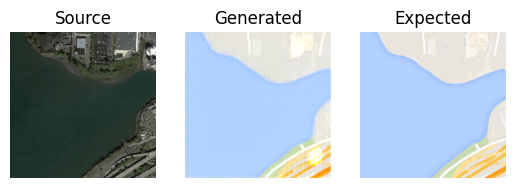

In [ ]:
def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Source', 'Generated', 'Expected']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()


model_G = keras.models.load_model("generator_epoch_2000.h5")

from tensorflow.keras.optimizers import Adam
model_G.compile(loss=['binary_crossentropy', 'mae'], optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[1,100])

# Generate and visualize results
[X1, X2] = dataset
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model_G.predict(src_image)
plot_images(src_image, gen_image, tar_image)

#Evaluating Model Robustness Using PSNR and SSIM Metrics

This part computes the Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index (SSIM) between the predicted outputs and the ground truth maps for each distortion type. It summarizes the average scores to assess the model's robustness.

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def evaluate_metrics(gt, pred):
    psnr_val = psnr(gt, pred, data_range=1.0)
    ssim_val = ssim(gt, pred, data_range=1.0, channel_axis=-1, win_size=7)
    return psnr_val, ssim_val

metrics = {
    'original': [],
    'noisy': [],
    'blurred': [],
    'occluded': []
}

for gt_img, output in zip(test_targets, results):
    for key in output:
        p, s = evaluate_metrics(gt_img, output[key])
        metrics[key].append((p, s))



In [ ]:
import numpy as np

def summarize_metrics(metrics):
    for key in metrics:
        if not metrics[key]:  # If the list is empty
            print(f"{key.upper()}: No data to evaluate.\n")
            continue
        psnrs, ssims = zip(*metrics[key])
        print(f"{key.upper()}:")
        print(f"  Average PSNR: {np.mean(psnrs):.2f}")
        print(f"  Average SSIM: {np.mean(ssims):.4f}\n")


In [ ]:
print("Length of corrupted_images:", len(corrupted_images))
print("Length of results:", len(results))


Length of corrupted_images: 10
Length of results: 10


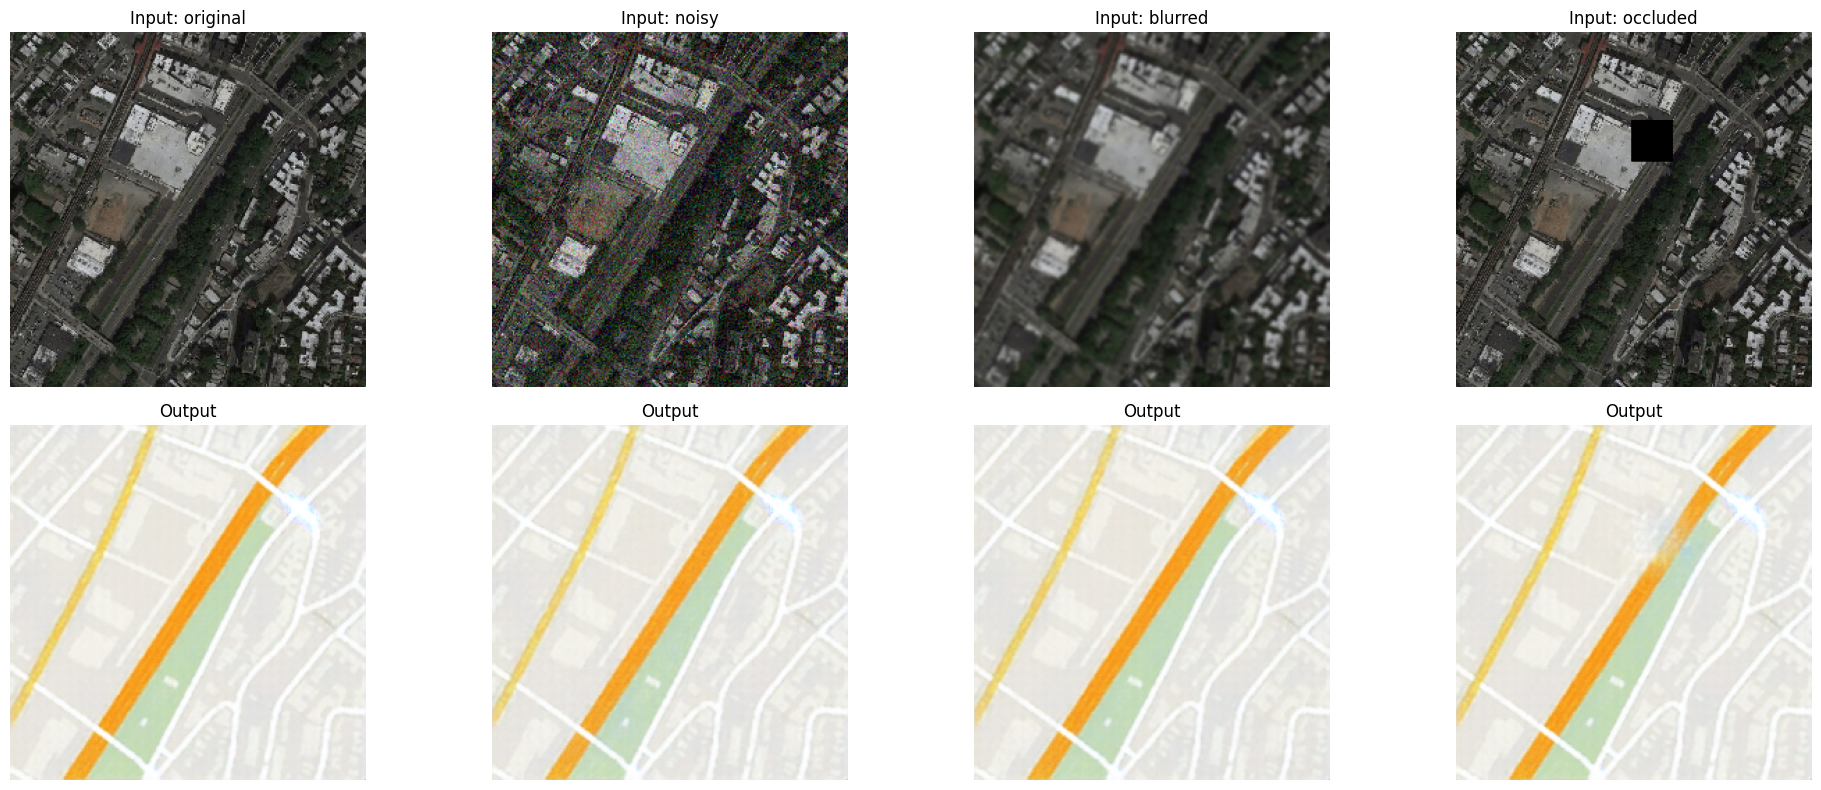

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(index=0):
    fig, axs = plt.subplots(2, 4, figsize=(20, 8))
    versions = ['original', 'noisy', 'blurred', 'occluded']

    for i, v in enumerate(versions):
        axs[0, i].imshow(corrupted_images[index][v])
        axs[0, i].set_title(f"Input: {v}")
        axs[0, i].axis('off')

        axs[1, i].imshow(results[index][v])
        axs[1, i].set_title(f"Output")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Try displaying one image
plot_comparison(index=1)


In [ ]:
# Check value ranges
print("Ground truth image:", np.min(test_targets[0]), "to", np.max(test_targets[0]))
print("Generated output:", np.min(results[0]['original']), "to", np.max(results[0]['original']))


Ground truth image: 0.4117647 to 1.0
Generated output: 0.54845786 to 0.9999823


# PSNR and SSIM Scores Across Distortions

This block calculates and prints the average PSNR and SSIM scores for each distortion type (original, noisy, blurred, occluded), giving a quick summary of the model’s robustness performance across different perturbations.

In [ ]:
def summarize_metrics(metrics):
    psnr_scores = {}
    ssim_scores = {}

    for key in metrics:
        if not metrics[key]:
            continue
        psnrs, ssims = zip(*metrics[key])
        psnr_scores[key] = np.mean(psnrs)
        ssim_scores[key] = np.mean(ssims)

    return psnr_scores, ssim_scores

# Get summarized scores
psnr_scores, ssim_scores = summarize_metrics(metrics)

print("PSNR Scores:")
for k, v in psnr_scores.items():
    print(f"{k}: {v:.2f}")

print("\nSSIM Scores:")
for k, v in ssim_scores.items():
    print(f"{k}: {v:.4f}")


PSNR Scores:
original: 30.99
noisy: 30.51
blurred: 30.46
occluded: 30.48

SSIM Scores:
original: 0.8415
noisy: 0.8287
blurred: 0.8285
occluded: 0.8342


In [ ]:
def quick_check(index=0):
    import matplotlib.pyplot as plt

    versions = ['original', 'noisy', 'blurred', 'occluded']
    fig, axs = plt.subplots(2, 5, figsize=(20, 6))

    for i, v in enumerate(versions):
        # Row 1: Show corrupted inputs
        axs[0, i].imshow(corrupted_images[index][v])
        axs[0, i].set_title(f"Input: {v}")
        axs[0, i].axis('off')

        # Row 2: Show model outputs
        axs[1, i].imshow(results[index][v])
        axs[1, i].set_title(f"Output: {v}")
        axs[1, i].axis('off')

    # Last column: Ground truth
    axs[0, 4].imshow(test_targets[index])
    axs[0, 4].set_title("Ground Truth")
    axs[0, 4].axis('off')

    axs[1, 4].axis('off')  # Leave bottom-right cell empty

    plt.tight_layout()
    plt.show()


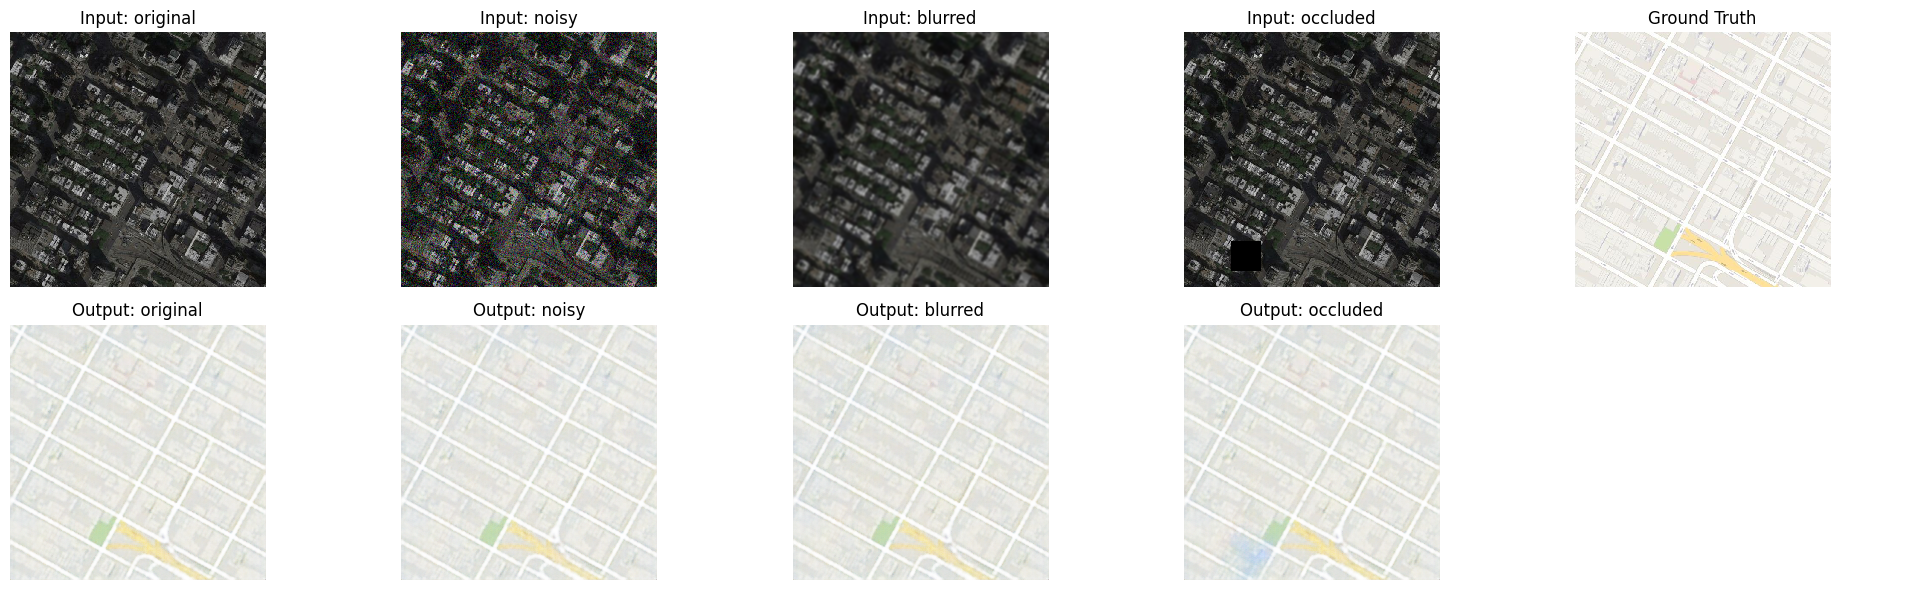

In [ ]:
quick_check(index=0)  # Change index to try different test samples


#Output Results Visualisation

In [ ]:
def summarize_metrics(results, test_targets):
    conditions = ['original', 'noisy', 'blurred', 'occluded']
    metrics = {k: [] for k in conditions}

    for i, gt in enumerate(test_targets):
        for k in conditions:
            p, s = evaluate_metrics(gt, results[i][k])
            metrics[k].append((p, s))

    psnr_scores = {k: np.mean([m[0] for m in v]) for k, v in metrics.items()}
    ssim_scores = {k: np.mean([m[1] for m in v]) for k, v in metrics.items()}
    return psnr_scores, ssim_scores


In [ ]:
def plot_metrics(psnr_scores, ssim_scores):
    import matplotlib.pyplot as plt

    conditions = list(psnr_scores.keys())

    # PSNR Bar Chart
    plt.figure(figsize=(8, 4))
    plt.bar(conditions, psnr_scores.values(), color='skyblue')
    plt.title("PSNR Scores Across Distortions")
    plt.ylabel("PSNR (dB)")
    plt.ylim([min(psnr_scores.values()) - 1, max(psnr_scores.values()) + 1])
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


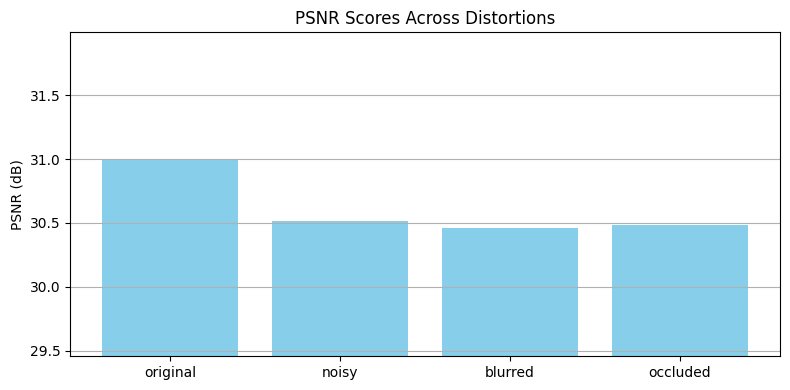

In [ ]:
psnr_scores, ssim_scores = summarize_metrics(results, test_targets)
plot_metrics(psnr_scores, ssim_scores)


In [ ]:
def plot_metrics(psnr_scores, ssim_scores):
    import matplotlib.pyplot as plt

    conditions = list(psnr_scores.keys())

    # SSIM Bar Chart - improved y-axis range for better visibility
    plt.figure(figsize=(8, 4))
    plt.bar(conditions, ssim_scores.values(), color='lightgreen')
    plt.title("SSIM Scores Across Distortions")
    plt.ylabel("SSIM (0–1)")

    min_ssim = min(ssim_scores.values())
    max_ssim = max(ssim_scores.values())
    margin = 0.01  # add a little breathing space

    # Zoomed-in y-axis range to make bars more distinguishable
    plt.ylim([min_ssim - margin, max_ssim + margin])

    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [ ]:
psnr_scores, ssim_scores = summarize_metrics(results, test_targets)
plot_metrics(psnr_scores, ssim_scores)
